# FOPRA 109 (change path below)

In [2]:
#Code group FPGROUPFOPRA
import numpy as np
import struct
import matplotlib.pyplot as plt
import scipy
import os
from scipy.optimize import least_squares
from lmfit.models import GaussianModel

#Select right path if you are Fred or Pram!
#path_to_data = '/Users/fredsimoes78/Desktop/fopra_109/' #Path for Fred
path_to_data = 'C:\\Users\\prame\\Documents\\academic\\Masters\\fopra_109' # Path for Pram

In [3]:
# Create a directory to save the plots
os.makedirs("plots", exist_ok=True)

# Function to automatically save each plot
def save_current_plot(filename):
    plt.savefig(os.path.join("plots", filename))
    

### Waveform Analysis -> Acquisition 0

In [5]:
def read_file(file): #read binary data
    dfile = open(file, "rb")
    dfile.seek(21) # Position where n_samples is saved in the file -> it's the line offset for actual information
    n_samples = struct.unpack( 'i ', dfile.read(4))[0] 
    datatype = np.dtype([
                        ( 'board',      np.uint16),
                        ( 'channel' ,   np.uint16),
                        ( 'timestamp',  np.uint64),
                        ( 'energy',     np.uint16),
                        ( 'flags',      np.uint32),
                        ( 'wavecode' ,  np.uint8),
                        ( 'n_samples',  np.uint32),
                        ( 'wave',       np.int16, n_samples)])
    dfile.seek(2)
    data = np.fromfile(dfile, dtype=datatype) 
    return data

In [3]:
#Understand data
binary00 =  path_to_data + '/run_07_08_2024_0/RAW/DataR_CH0@DT5725SB_13964_run_07_08_2024_0.BIN' #aq0.ch0 
binary01 =  path_to_data + '/run_07_08_2024_0/RAW/DataR_CH1@DT5725SB_13964_run_07_08_2024_0.BIN' #aq0.ch1 

data00 = read_file(binary00) #(112905,) numpy.ndarray -> 112905 waveforms/events
data01 = read_file(binary01) #(121233,) numpy.ndarray
#each element is (7, (5000)) like datatype in the function (n_samples=5000)

print(data00.shape)
print(data01.shape)
print(data00[0])
print(data00[1])
print(data01[0])

(112905,)
(121233,)
(0, 0, 733104000, 1354, 0, 1, 5000, [4966, 4966, 4972, ..., 5165, 5160, 5160])
(0, 0, 1901200000, 1508, 0, 1, 5000, [4975, 4975, 4976, ..., 5232, 5225, 5225])
(0, 1, 8329532000, 1600, 0, 1, 5000, [5078, 5078, 5080, ..., 5385, 5390, 5390])


'COMMENTS\nEach waveform IS ALREADY AN ENERGY EVENT -> DAQ/software removed reset part that was seen in the oscilloscope!!!!\nABNORMAL EVENTS:\n-> wf start with exp tail going up -> reset just happened before -> not a problem\n-> double event! -> 2 jumps and energy is overestimated\n-> HUGE WIGGLE -> Has to be a RESET!!! -> Gives negative energy later'

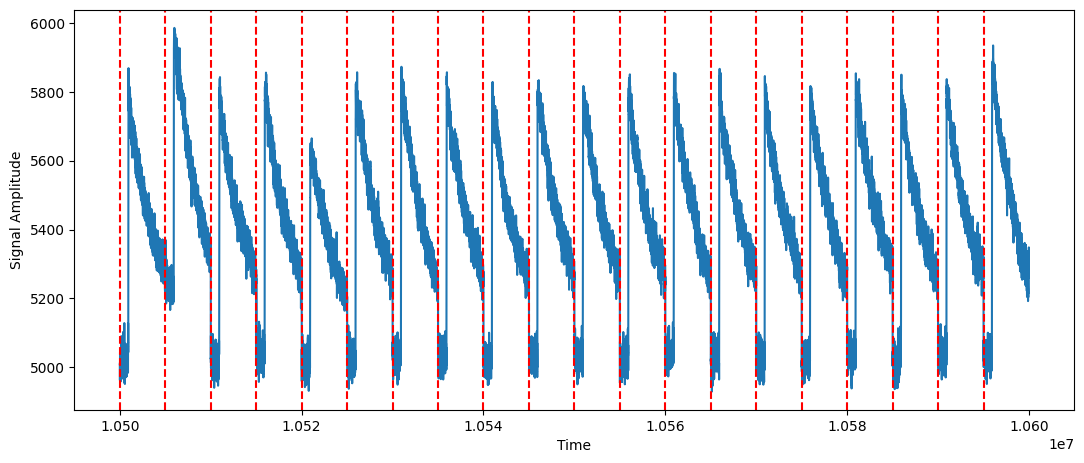

In [46]:
#To search for abnormal waveforms, look at a lot of data at once
data00_full = np.concatenate(( [ data00[i][7] for i in range(data00.shape[0]) ] ))

fig= plt.figure(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])

start,stop = 10500000,10600000 #play with this to see every type of wf
xx = np.arange(start,stop)
vertical = np.arange(start,stop,5000)
ax.plot(xx, data00_full[start:stop])
save_current_plot("Combined_Waveforms.png")

for v in vertical: ax.axvline(v, linestyle='--',color='r')

ax.set_xlabel('Time')
ax.set_ylabel('Signal Amplitude')

#Put all waveforms together into one array:
data00_all = np.reshape( data00_full, (-1,5000)) #shape (112905,5000)

"""COMMENTS
Each waveform IS ALREADY AN ENERGY EVENT -> DAQ/software removed reset part that was seen in the oscilloscope!!!!
ABNORMAL EVENTS:
-> wf start with exp tail going up -> reset just happened before -> not a problem
-> double event! -> 2 jumps and energy is overestimated
-> HUGE WIGGLE -> Has to be a RESET!!! -> Gives negative energy later"""

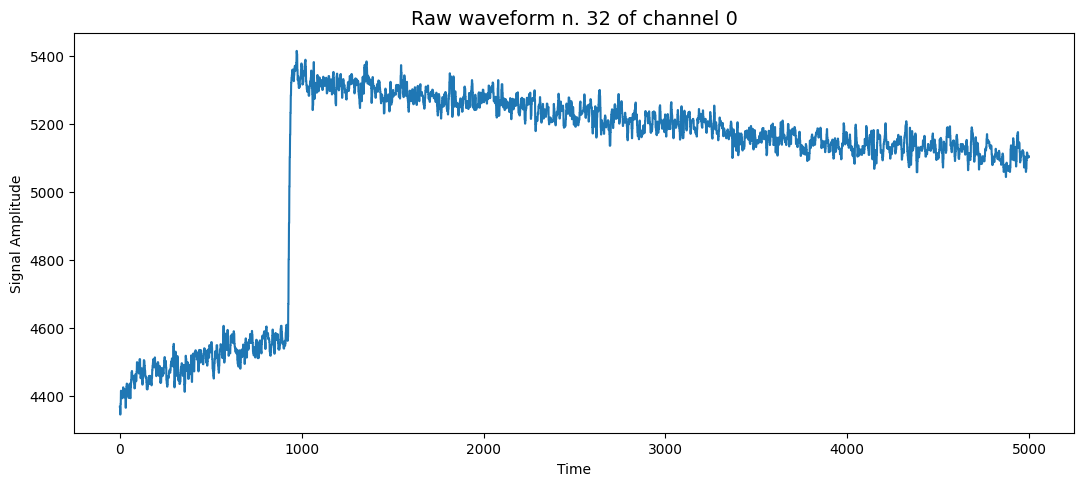

In [47]:
#Waveforms
fig= plt.figure(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])

i = 0 #wf1 -> Normal
i = 31 #wf2 -> Reset just happened before, couple more like that which is no problem for energy evaluation
#i = 54 #wf3 -> Double energy event, i=91, i=279, i=549 also 
#i = 544 #wf4 -> HUGE JUMP, i = 704 also and i = 855, i = 1104

ax.plot(data00_all[i])

ax.set_title(f"Raw waveform n. {i+1} of channel 0", fontsize='14')
ax.set_xlabel('Time')
ax.set_ylabel('Signal Amplitude')
save_current_plot("Raw_Waveform_32_ch0.png")

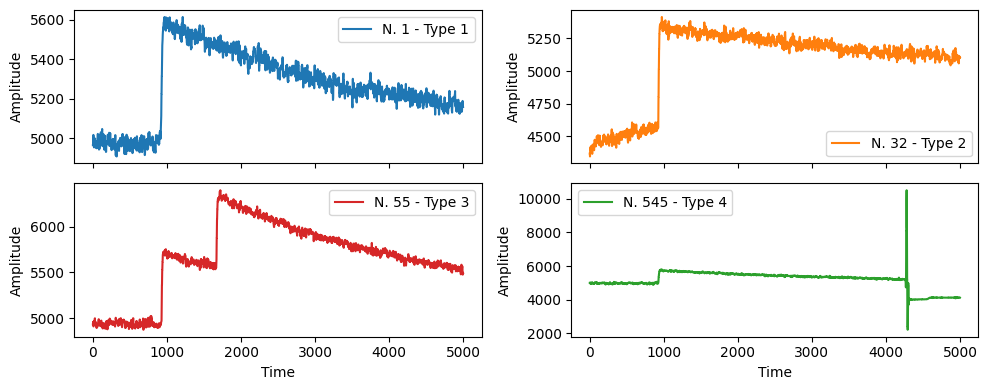

In [48]:
#For report -> All in one picture
fig, axs = plt.subplots(2, 2, sharex = True, figsize=(10,4))

i,j,k,l = 0,31,54,544

axs[0,0].plot(data00_all[i], label = f'N. {i+1} - Type 1', color = 'tab:blue')
axs[0,1].plot(data00_all[j], label = f'N. {j+1} - Type 2', color = 'tab:orange')
axs[1,0].plot(data00_all[k], label = f'N. {k+1} - Type 3', color = 'tab:red')
axs[1,1].plot(data00_all[l], label = f'N. {l+1} - Type 4', color = 'tab:green')

axs[1,0].set_xlabel('Time')
axs[1,1].set_xlabel('Time')

for ax in axs.flatten(): ax.set_ylabel('Amplitude'); ax.legend()
fig.tight_layout()
save_current_plot("Waveforms.png")

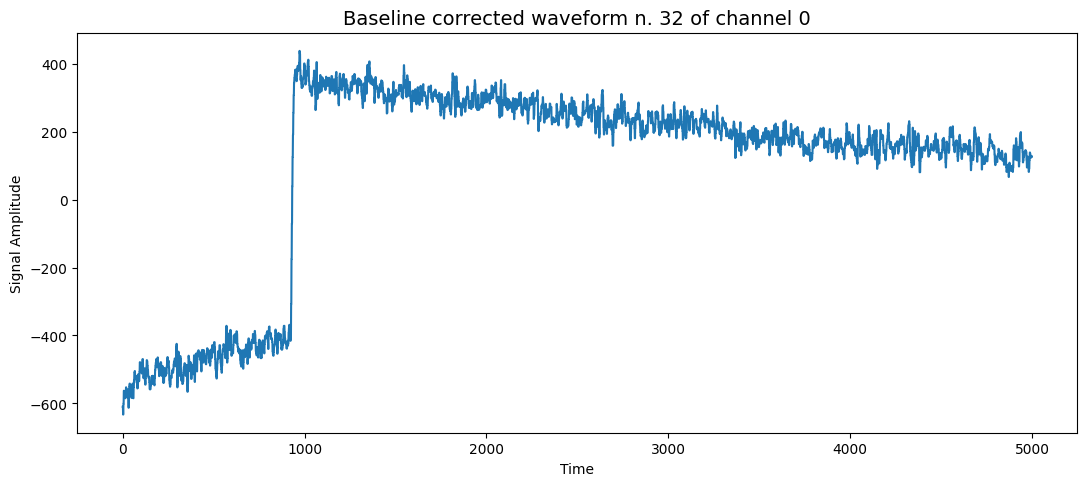

In [49]:
#Take off baseline -> average first 500 samples (2 microseconds -> time step is 4 ns) and remove from every waveform
data00_base = data00_all - np.average(data00_all[0,:500])

fig= plt.figure(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])

i = 0 #wf1 
i = 31 #wf2 
#i = 54 #wf3 
#i = 544 #wf4 

ax.plot(data00_base[i])

ax.set_title(f"Baseline corrected waveform n. {i+1} of channel 0", fontsize='14')
ax.set_xlabel('Time')
ax.set_ylabel('Signal Amplitude')
save_current_plot("Baseline_Corrected_Waveforms.png")

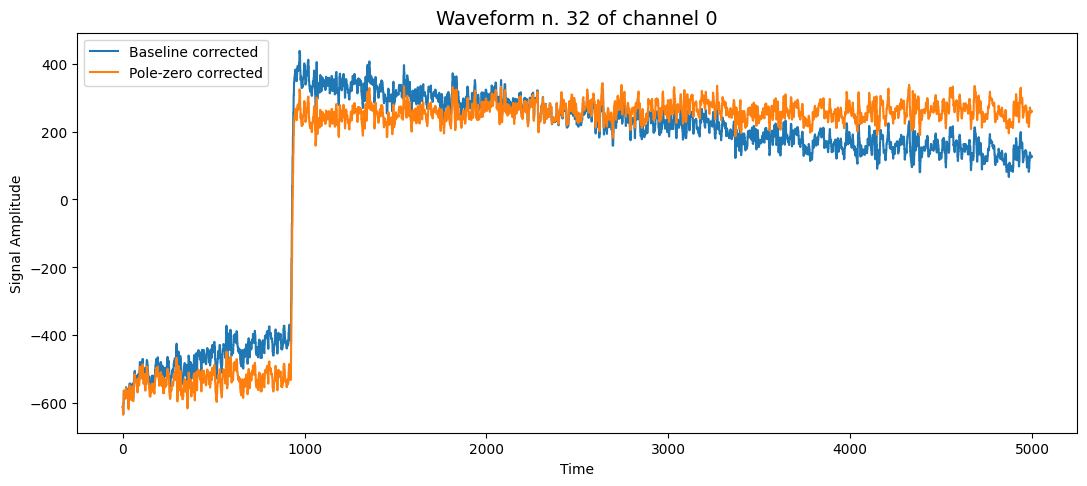

In [50]:
#Deconvolve use scipy filter
#Each step is 4ns so 15 microseconds is 3750 steps
#a[0]*y[n] = b[0]*x[n] + b[1]*x[n-1] - a[1]*y[n-1] <=> y[n] = x[n] - alpha*x[n-1] + y[n-1]

alpha = np.exp(-1/3750) #in sample units
data00_filtered = scipy.signal.lfilter( b = np.array([1,-alpha]), a = np.array([1,-1]), x = data00_base, axis = -1)

fig= plt.figure(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])

i = 0 #wf1 
i = 31 #wf2 
#i = 54 #wf3 
#i = 544 #wf4 

ax.plot(data00_base[i], label='Baseline corrected')
ax.plot(data00_filtered[i], label='Pole-zero corrected')

ax.set_title(f"Waveform n. {i+1} of channel 0", fontsize='14')
ax.set_xlabel('Time')
ax.set_ylabel('Signal Amplitude')
plt.legend()
save_current_plot("BaslineCorrected_vs_Polezerocorrected.png")

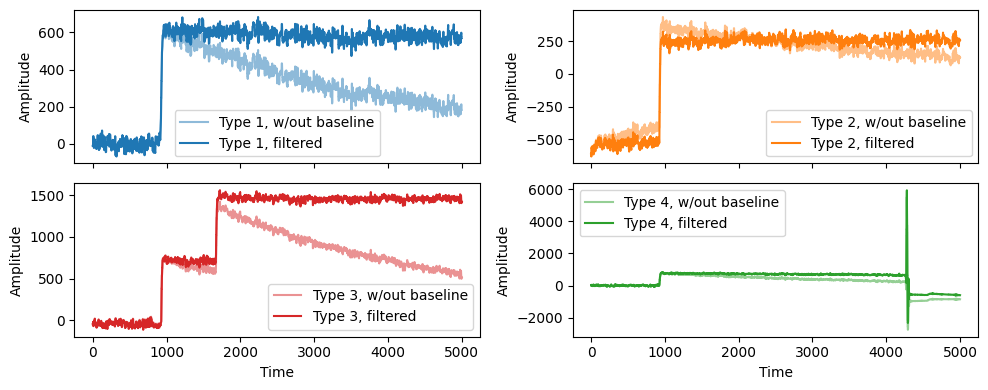

In [51]:
#For report -> All in one picture
fig, axs = plt.subplots(2, 2, sharex = True, figsize=(10,4))

i,j,k,l = 0,31,54,544

axs[0,0].plot(data00_base[i], label = 'Type 1, w/out baseline', color = 'tab:blue',   alpha=0.5)
axs[0,1].plot(data00_base[j], label = 'Type 2, w/out baseline', color = 'tab:orange', alpha=0.5)
axs[1,0].plot(data00_base[k], label = 'Type 3, w/out baseline', color = 'tab:red',    alpha=0.5)
axs[1,1].plot(data00_base[l], label = 'Type 4, w/out baseline', color = 'tab:green',  alpha=0.5)

axs[0,0].plot(data00_filtered[i], label = 'Type 1, filtered', color = 'tab:blue')
axs[0,1].plot(data00_filtered[j], label = 'Type 2, filtered', color = 'tab:orange')
axs[1,0].plot(data00_filtered[k], label = 'Type 3, filtered', color = 'tab:red')
axs[1,1].plot(data00_filtered[l], label = 'Type 4, filtered', color = 'tab:green')

axs[1,0].set_xlabel('Time')
axs[1,1].set_xlabel('Time')

for ax in axs.flatten(): ax.set_ylabel('Amplitude'); ax.legend()
fig.tight_layout()
save_current_plot("filtered_vs_wobaseline.png")

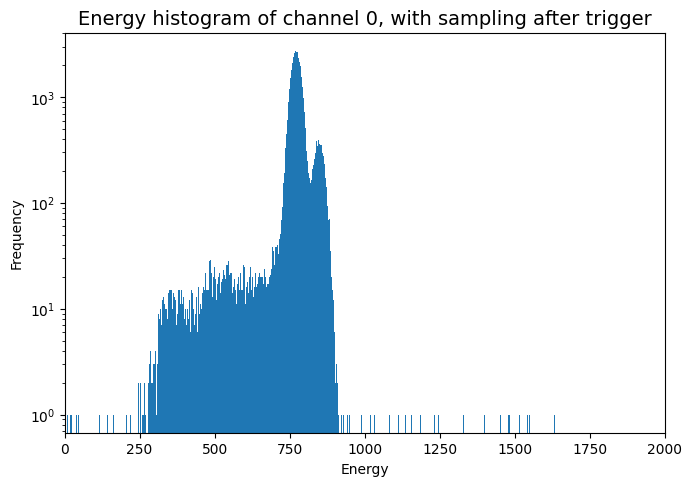

In [52]:
#Histogram of energies, having read every possible event

#wf3 -> to work we have to average something like 1050:1250 -> Show with and without that!
#wf4 -> they give negative energy BUT wf3 solution also solves this!
energies1 = np.average(data00_filtered[:,-500:], axis = -1) - np.average(data00_filtered[:,:500], axis = -1) #WITHOUT IMPROVEMENT
energies2 = np.average(data00_filtered[:,1050:1250], axis = -1) - np.average(data00_filtered[:,:500], axis = -1) #WITH IMPROVEMENT

fig= plt.figure(figsize=(6,4))
ax = fig.add_axes([0,0,1,1])

#ax.hist(energies1, bins=10000)
#ax.set_title("Energy histogram of channel 0, with sampling from end", fontsize='14')

ax.hist(energies2, bins=10000)
ax.set_title("Energy histogram of channel 0, with sampling after trigger", fontsize='14')

ax.set_xlabel('Energy')
ax.set_xlim([0,2000])
ax.set_ylabel('Frequency')
ax.set_yscale('log')
save_current_plot("Ch0_hist_sampaftertrigger.png")

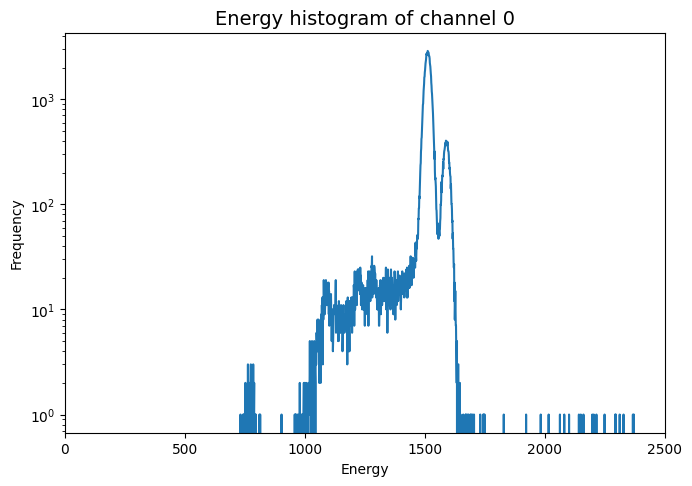

In [53]:
#look at energy spectra to compare

spectrum = np.loadtxt(path_to_data + '/run_07_08_2024_0/RAW/CH0@DT5725SB_13964_EspectrumR_run_07_08_2024_0_20240807_113118.txt')

fig= plt.figure(figsize=(6,4))
ax = fig.add_axes([0,0,1,1])
ax.plot(spectrum)
ax.set_title("Energy histogram of channel 0", fontsize='14')
ax.set_xlabel('Energy')
ax.set_xlim([0,2500])
ax.set_ylabel('Frequency')
ax.set_yscale('log')
save_current_plot("Ch0_hist.png")
#Conclusions:
#Software uses trapezoid method which is better -> probably takes care of wf outliers much better
#Calibration is slightly different -> trapezoid probably has a scaling constant (which is irrelevant)
#Even averaging after triggering, some outliers and discrepancies remain

C:\Users\prame\AppData\Local\Temp\ipykernel_736\373665868.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
C:\Users\prame\AppData\Local\Temp\ipykernel_736\2604189448.py:6: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join("plots", filename))


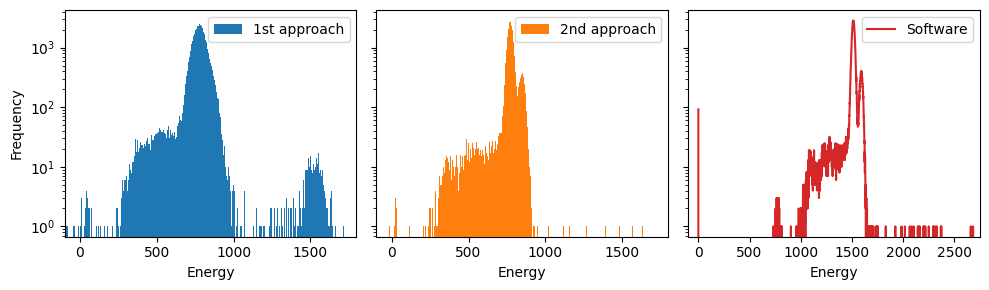

In [54]:
#For report -> All in one picture

fig, axs = plt.subplots(1, 3, sharey = True, figsize=(10,3))

axs[0].hist(energies1, bins = 10000, label = '1st approach', color = 'tab:blue')
axs[1].hist(energies2, bins = 10000, label = '2nd approach', color = 'tab:orange')
axs[2].plot(spectrum,  label = 'Software', color = 'tab:red')

axs[0].set_ylabel('Frequency')
axs[0].set_xlim([-100,1800])
axs[1].set_xlim([-100,1800])
axs[2].set_xlim([-100,2750])
for ax in axs: ax.set_xlabel('Energy'); ax.set_yscale('log'); ax.legend()
fig.tight_layout()
save_current_plot("allhist.png")

### Spectrum analysis -> Acquisition 1

In [4]:
def read_file_spect(file): #read spectrum
    dfile = open(file, "rb")
    dfile.seek(21) # Position where n_samples is saved in the file -> it's the line offset for actual information
    n_samples = struct.unpack( 'i ', dfile.read(4))[0] 
    datatype = np.dtype([
                        ( 'board',      np.uint16),
                        ( 'channel' ,   np.uint16),
                        ( 'timestamp',  np.uint64),
                        ( 'energy',     np.uint16),
                        ( 'flags',      np.uint32),
                        #( 'wavecode' ,  np.uint8),
                        #( 'n_samples',  np.uint32),
                        #( 'wave',       np.int16, n_samples)
    ])
    dfile.seek(2)
    data = np.fromfile(dfile, dtype=datatype) 
    return data

In [5]:
spect10 = path_to_data + '/run_07_08_2024_1/RAW/DataR_CH0@DT5725SB_13964_run_07_08_2024_1.BIN' #aq1.ch0 
spect11 = path_to_data + '/run_07_08_2024_1/RAW/DataR_CH1@DT5725SB_13964_run_07_08_2024_1.BIN' #aq1.ch1
spect12 = path_to_data + '/run_07_08_2024_1/RAW/DataR_CH2@DT5725SB_13964_run_07_08_2024_1.BIN' #aq1.ch2
spect13 = path_to_data + '/run_07_08_2024_1/RAW/DataR_CH3@DT5725SB_13964_run_07_08_2024_1.BIN' #aq1.ch3
spect14 = path_to_data + '/run_07_08_2024_1/RAW/DataR_CH4@DT5725SB_13964_run_07_08_2024_1.BIN' #aq1.ch4
spect15 = path_to_data + '/run_07_08_2024_1/RAW/DataR_CH5@DT5725SB_13964_run_07_08_2024_1.BIN' #aq1.ch5
spect16 = path_to_data + '/run_07_08_2024_1/RAW/DataR_CH6@DT5725SB_13964_run_07_08_2024_1.BIN' #aq1.ch6

ch0 = read_file_spect(spect10) #shape (363017,) -> 363017 energy events, ch0['energy'] are the energy values
ch1 = read_file_spect(spect11)
ch2 = read_file_spect(spect12)
ch3 = read_file_spect(spect13)
ch4 = read_file_spect(spect14)
ch5 = read_file_spect(spect15)
ch6 = read_file_spect(spect16)

datanames = {'Channel 0': ch0, 'Channel 1': ch1, 'Channel 2': ch2, 'Channel 3': ch3, 'Channel 4': ch4, 'Channel 5': ch5, 'Channel 6': ch6}

s_0 = np.loadtxt(path_to_data + '/run_07_08_2024_1/RAW/CH0@DT5725SB_13964_EspectrumR_run_07_08_2024_1_20240807_114824.txt')
s_1 = np.loadtxt(path_to_data + '/run_07_08_2024_1/RAW/CH1@DT5725SB_13964_EspectrumR_run_07_08_2024_1_20240807_114824.txt')
s_2 = np.loadtxt(path_to_data + '/run_07_08_2024_1/RAW/CH2@DT5725SB_13964_EspectrumR_run_07_08_2024_1_20240807_114824.txt')
s_3 = np.loadtxt(path_to_data + '/run_07_08_2024_1/RAW/CH3@DT5725SB_13964_EspectrumR_run_07_08_2024_1_20240807_114824.txt')
s_4 = np.loadtxt(path_to_data+ '/run_07_08_2024_1/RAW/CH4@DT5725SB_13964_EspectrumR_run_07_08_2024_1_20240807_114824.txt')
s_5 = np.loadtxt(path_to_data+ '/run_07_08_2024_1/RAW/CH5@DT5725SB_13964_EspectrumR_run_07_08_2024_1_20240807_114824.txt')
s_6 = np.loadtxt(path_to_data + '/run_07_08_2024_1/RAW/CH6@DT5725SB_13964_EspectrumR_run_07_08_2024_1_20240807_114824.txt')

spectnames={'Channel 0': s_0, 'Channel 1': s_1, 'Channel 2': s_2, 'Channel 3': s_3, 'Channel 4': s_4, 'Channel 5': s_5, 'Channel 6': s_6}

In Channel 0 there were 363017 energy events
In Channel 1 there were 390407 energy events
In Channel 2 there were 361405 energy events
In Channel 3 there were 824628 energy events
In Channel 4 there were 364488 energy events
In Channel 5 there were 819025 energy events
In Channel 6 there were 366931 energy events


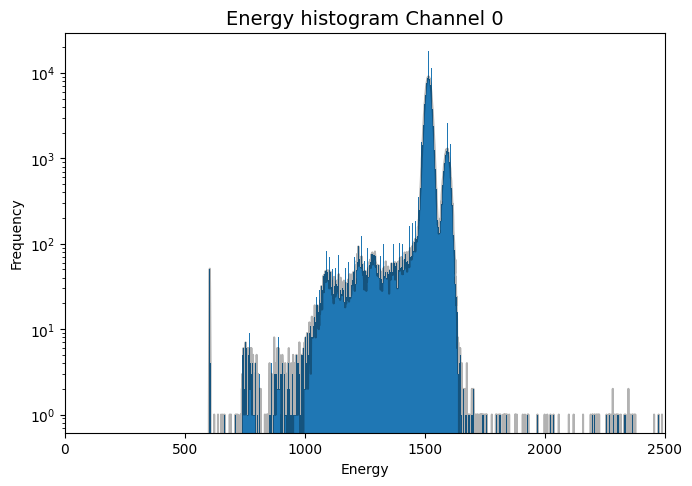

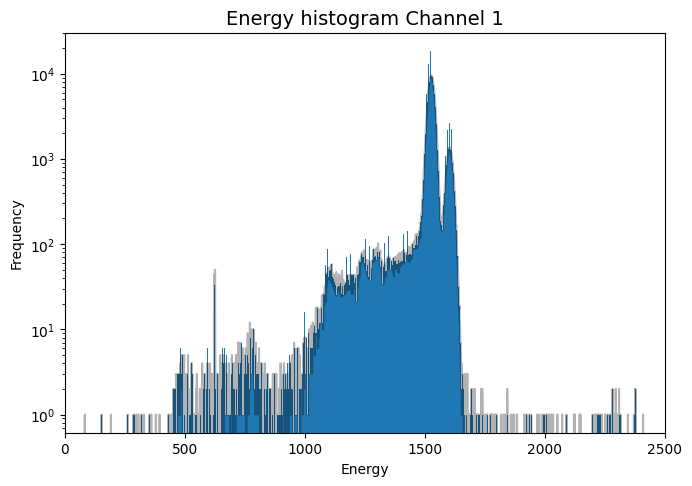

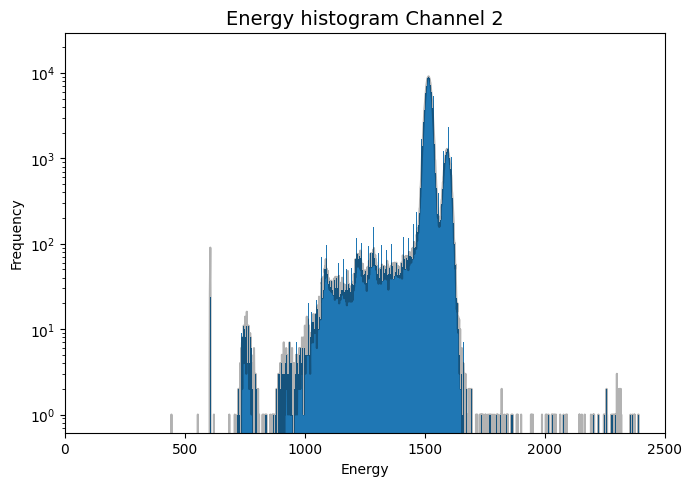

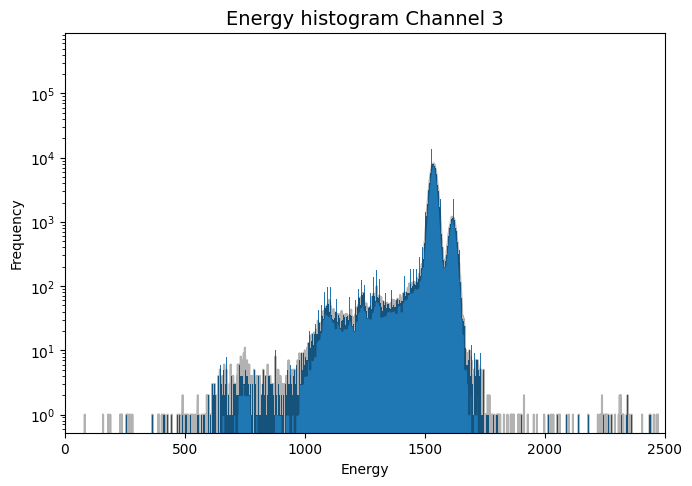

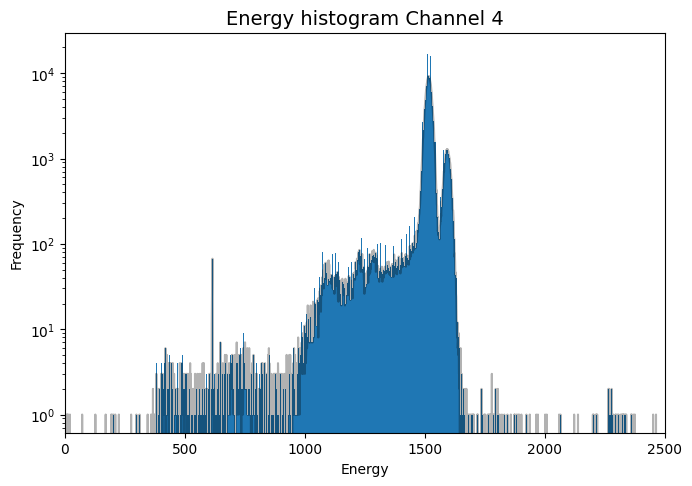

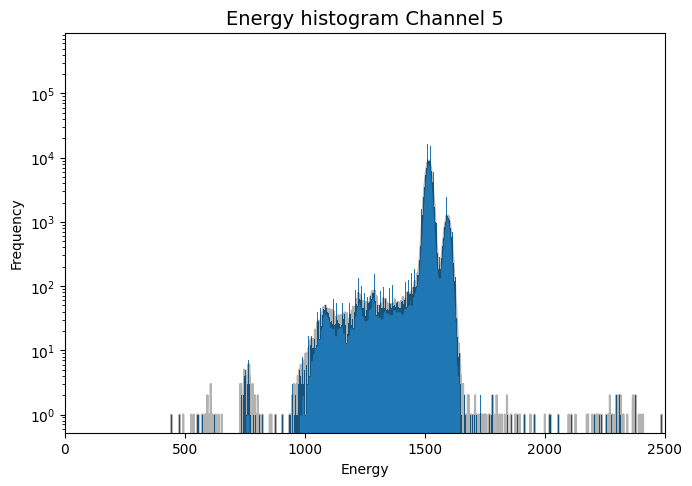

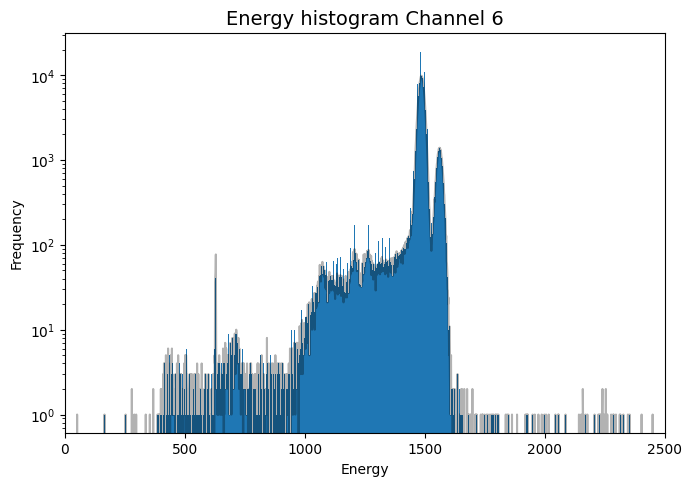

In [5]:
#histogram of each channel
for name, data in datanames.items():
    energies = data['energy']
    print('In',name,'there were',energies.shape[0],'energy events')
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_axes([0,0,1,1])

    ax.hist(energies, bins=10000)
    ax.set_title("Energy histogram "+name, fontsize='14')
    ax.set_xlabel('Energy')
    ax.set_xlim([0,2500]) #to remove outliers from view
    ax.set_ylabel('Frequency')
    ax.set_yscale('log')

    #check consistency -> n_bins = 10000 garantees consistency approximately in amplitude
    ax.plot(spectnames[name], alpha = 0.3, color = 'k')
    save_current_plot("hist" + name + ".png")

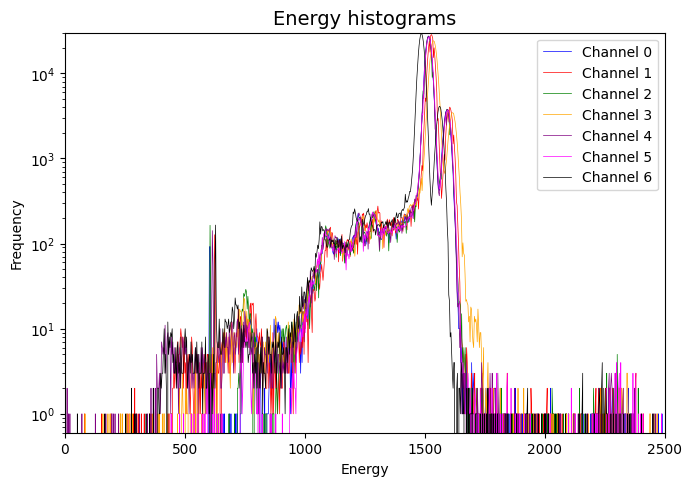

In [6]:
#To plot histograms on top of each other, it's better to do it with numpy, so we have a solid line to plot

#This is how to do it
#counts, bin_edges = np.histogram(values, bins=10000)
#bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
#.plot(bin_midpoints, counts)

#combine histograms of all channels

colors = {'Channel 0': 'Blue', 'Channel 1': 'Red', 'Channel 2': 'Green', 'Channel 3': 'Orange',
           'Channel 4': 'Purple', 'Channel 5': 'Magenta', 'Channel 6': 'Black'}

fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Energy histograms", fontsize='14')
ax.set_xlabel('Energy')
ax.set_xlim([0,2500]) #to remove outliers from view
ax.set_ylim([0.6,30000])
ax.set_ylabel('Frequency')
ax.set_yscale('log')

#histogram of each channel
i=0
for name, data in datanames.items():
    #if i==4: break
    energies = data['energy']

    counts, bin_edges = np.histogram(energies, bins=4000)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.plot(bin_midpoints, counts, label=name, alpha=1, color= colors[name], linewidth = 0.5)
    #i +=1
plt.legend()
#save_current_plot("combined_hist.png")
plt.show()

#This looks better than the filled histograms


'\naxs[1].hist(np.concatenate((ch0[\'energy\'],ch1[\'energy\'],ch2[\'energy\'],\n                           ch3[\'energy\'],ch4[\'energy\'],ch5[\'energy\'],\n                           ch6[\'energy\'])), bins=10000, label=\'All\', alpha = 0.5)\naxs[1].set_title("Uncalibrated energy spectra of all channels combined", fontsize=\'14\')\naxs[1].set_xlabel(\'Energy\')\naxs[1].set_xlim([0,2500]) #to remove outliers from view\naxs[1].set_ylabel(\'Frequency\')\naxs[1].set_yscale(\'log\')\naxs[1].legend()\n'

C:\Users\prame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


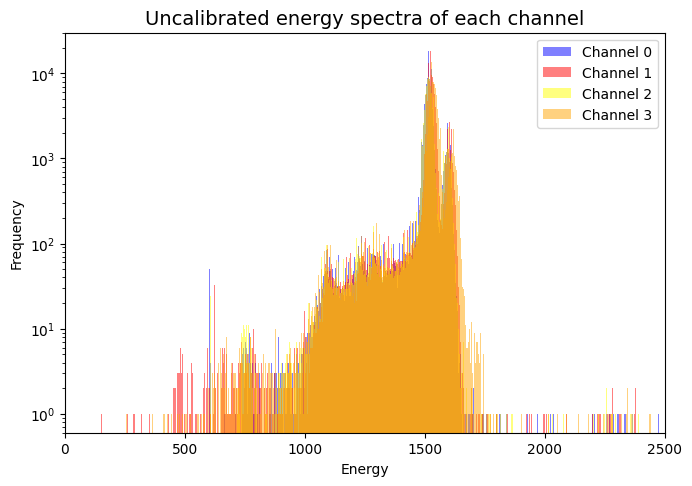

In [17]:
#On top of each other

fig = plt.figure(figsize=(6,4))
axs = fig.add_axes([0,0,1,1])

colors = {'Channel 0': 'Blue', 'Channel 1': 'Red', 'Channel 2': 'Yellow', 'Channel 3': 'Orange',
           'Channel 4': 'Purple', 'Channel 5': 'Green', 'Channel 6': 'Black'}

i=0
for name, data in datanames.items():
    if i==4: break
    axs.hist(data['energy'], bins=10000, label=name, alpha = 0.5, color= colors[name])
    i += 1
axs.set_title("Uncalibrated energy spectra of each channel", fontsize='14')
axs.set_xlabel('Energy')
axs.set_xlim([0,2500]) #to remove outliers from view
axs.set_ylim([0.6, 30000])
axs.set_ylabel('Frequency')
axs.set_yscale('log')
axs.legend()

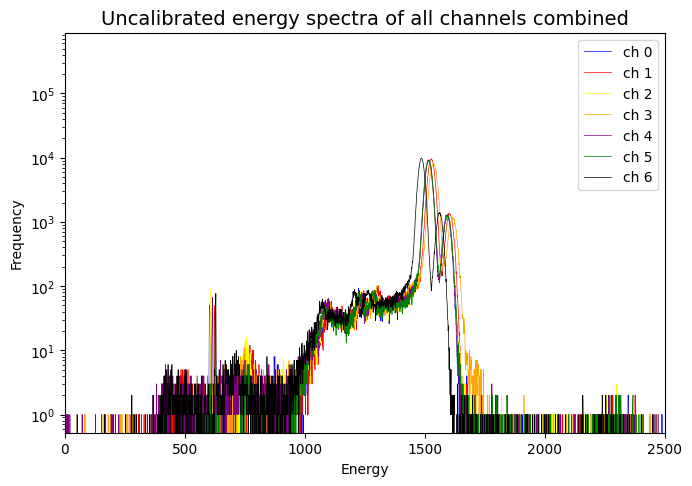

In [57]:
#Combine all spectrum -> Using the txt files here, I don't think that's what they ask in the task

fig= plt.figure(figsize=(6,4))
ax = fig.add_axes([0,0,1,1])

ax.plot(s_0, label='ch 0', color='Blue', linewidth = 0.5)
ax.plot(s_1, label='ch 1', color='Red', linewidth = 0.5)
ax.plot(s_2, label='ch 2', color='Yellow', linewidth = 0.5)
ax.plot(s_3, label='ch 3', color='Orange', linewidth = 0.5)
ax.plot(s_4, label='ch 4', color='Purple', linewidth = 0.5)
ax.plot(s_5, label='ch 5', color='Green', linewidth = 0.5)
ax.plot(s_6, label='ch 6', color='Black', linewidth = 0.5)

colors = {'Channel 0': 'Blue', 'Channel 1': 'Red', 'Channel 2': 'Yellow', 'Channel 3': 'Orange',
           'Channel 4': 'Purple', 'Channel 5': 'Green', 'Channel 6': 'Black'}

ax.set_title("Uncalibrated energy spectra of all channels combined", fontsize='14')
ax.set_xlabel('Energy')
ax.set_xlim([0,2500]) #to remove outliers from view
ax.set_ylabel('Frequency')
ax.set_yscale('log')
ax.legend()
save_current_plot("combined_uncal_hist.png")

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 88
    # data points      = 16383
    # variables        = 6
    chi-square         = 2138962.43
    reduced chi-square = 130.607707
    Akaike info crit   = 79827.2225
    Bayesian info crit = 79873.4465
    R-squared          = 0.99889330
[[Variables]]
    g1_amplitude:  295697.185 +/- 94.9540793 (0.03%) (init = 8000)
    g1_center:     1515.92350 +/- 0.00481183 (0.00%) (init = 1520)
    g1_sigma:      12.9783414 +/- 0.00481327 (0.04%) (init = 15)
    g2_amplitude:  42971.0486 +/- 97.5672393 (0.23%) (init = 3000)
    g2_center:     1593.02951 +/- 0.03592126 (0.00%) (init = 1600)
    g2_sigma:      13.7027588 +/- 0.03593321 (0.26%) (init = 10)
    g1_fwhm:       30.5616580 +/- 0.01133439 (0.04%) == '2.3548200*g1_sigma'
    g1_height:     9089.45999 +/- 2.91856292 (0.03%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_fwhm: 

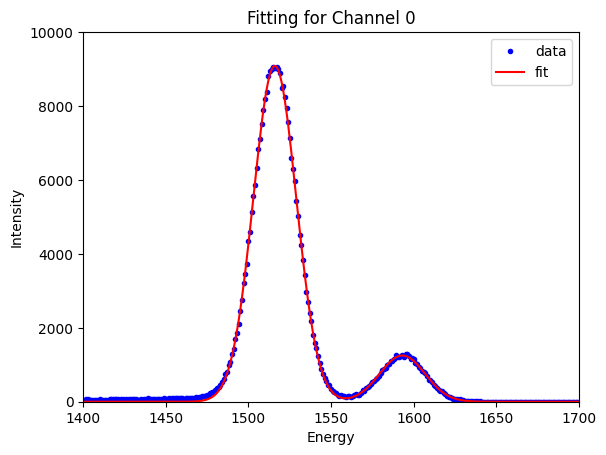

Peak 1: Mean = 1515.92, FWHM = 30.56
Peak 2: Mean = 1593.03, FWHM = 32.27
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 81
    # data points      = 16383
    # variables        = 6
    chi-square         = 2784343.06
    reduced chi-square = 170.015452
    Akaike info crit   = 84147.2737
    Bayesian info crit = 84193.4977
    R-squared          = 0.99871375
[[Variables]]
    g1_amplitude:  316136.818 +/- 109.469966 (0.03%) (init = 8000)
    g1_center:     1527.72983 +/- 0.00529634 (0.00%) (init = 1520)
    g1_sigma:      13.2483653 +/- 0.00529902 (0.04%) (init = 15)
    g2_amplitude:  45745.7158 +/- 111.488600 (0.24%) (init = 3000)
    g2_center:     1604.07094 +/- 0.03866326 (0.00%) (init = 1600)
    g2_sigma:      13.7412676 +/- 0.03868416 (0.28%) (init = 10)
    g1_fwhm:       31.1975155 +/- 0.01247823 (0.04%) == '2.3548200*g1_sigma'
    g1_height:     9519.69144 +/- 3.29595

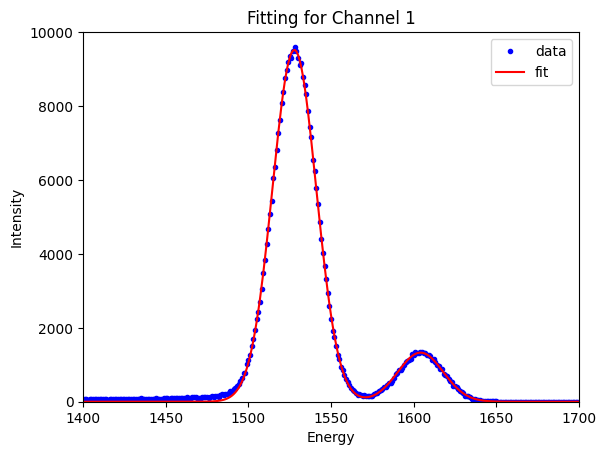

Peak 1: Mean = 1527.73, FWHM = 31.20
Peak 2: Mean = 1604.07, FWHM = 32.36
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 16383
    # variables        = 6
    chi-square         = 2149111.59
    reduced chi-square = 131.227428
    Akaike info crit   = 79904.7744
    Bayesian info crit = 79950.9984
    R-squared          = 0.99887333
[[Variables]]
    g1_amplitude:  293254.508 +/- 95.0255141 (0.03%) (init = 8000)
    g1_center:     1516.18604 +/- 0.00484001 (0.00%) (init = 1520)
    g1_sigma:      12.9367313 +/- 0.00484143 (0.04%) (init = 15)
    g2_amplitude:  43305.2646 +/- 98.6544687 (0.23%) (init = 3000)
    g2_center:     1594.16511 +/- 0.03667611 (0.00%) (init = 1600)
    g2_sigma:      13.9439241 +/- 0.03668736 (0.26%) (init = 10)
    g1_fwhm:       30.4636735 +/- 0.01140070 (0.04%) == '2.3548200*g1_sigma'
    g1_height:     9043.36848 +/- 2.93018

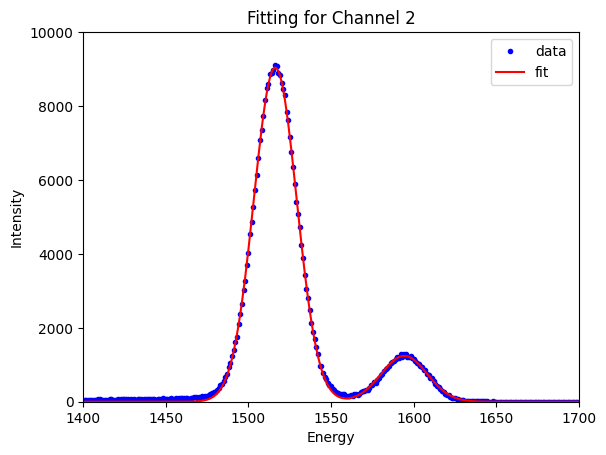

Peak 1: Mean = 1516.19, FWHM = 30.46
Peak 2: Mean = 1594.17, FWHM = 32.84
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 16383
    # variables        = 6
    chi-square         = 2.1088e+11
    reduced chi-square = 12876870.0
    Akaike info crit   = 268211.162
    Bayesian info crit = 268257.386
    R-squared          = 0.00780095
[[Variables]]
    g1_amplitude:  292551.042 +/- 31566.4847 (10.79%) (init = 8000)
    g1_center:     1536.70811 +/- 1.80730823 (0.12%) (init = 1520)
    g1_sigma:      14.5173306 +/- 1.81110253 (12.48%) (init = 15)
    g2_amplitude:  44654.1419 +/- 32755.4129 (73.35%) (init = 3000)
    g2_center:     1616.30895 +/- 13.2258020 (0.82%) (init = 1600)
    g2_sigma:      15.6227964 +/- 13.2551568 (84.84%) (init = 10)
    g1_fwhm:       34.1857005 +/- 4.26482049 (12.48%) == '2.3548200*g1_sigma'
    g1_height:     8039.42464 +/- 86

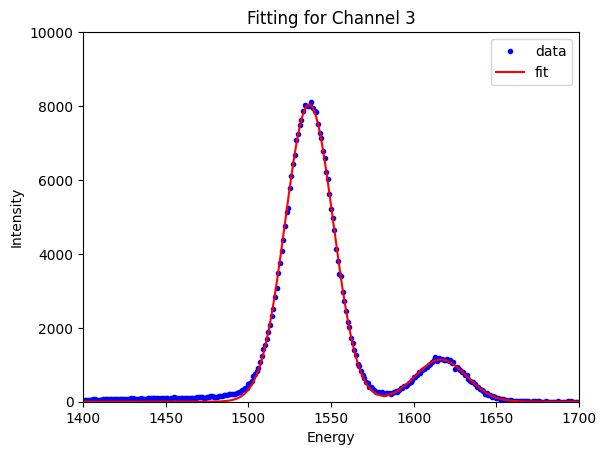

Peak 1: Mean = 1536.71, FWHM = 34.19
Peak 2: Mean = 1616.31, FWHM = 36.79
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 80
    # data points      = 16383
    # variables        = 6
    chi-square         = 2453119.02
    reduced chi-square = 149.790500
    Akaike info crit   = 82072.3393
    Bayesian info crit = 82118.5633
    R-squared          = 0.99873755
[[Variables]]
    g1_amplitude:  295031.149 +/- 101.189503 (0.03%) (init = 8000)
    g1_center:     1517.00084 +/- 0.00508988 (0.00%) (init = 1520)
    g1_sigma:      12.8528628 +/- 0.00509087 (0.04%) (init = 15)
    g2_amplitude:  42702.7893 +/- 103.472976 (0.24%) (init = 3000)
    g2_center:     1594.29984 +/- 0.03759977 (0.00%) (init = 1600)
    g2_sigma:      13.4392538 +/- 0.03760805 (0.28%) (init = 10)
    g1_fwhm:       30.2661783 +/- 0.01198807 (0.04%) == '2.3548200*g1_sigma'
    g1_height:     9157.52445 +/- 3.14067

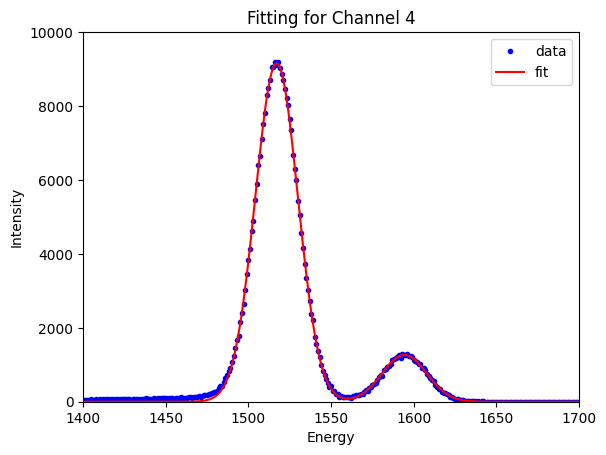

Peak 1: Mean = 1517.00, FWHM = 30.27
Peak 2: Mean = 1594.30, FWHM = 31.65
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 66
    # data points      = 16383
    # variables        = 6
    chi-square         = 2.1073e+11
    reduced chi-square = 12867645.0
    Akaike info crit   = 268199.421
    Bayesian info crit = 268245.645
    R-squared          = 0.00865459
[[Variables]]
    g1_amplitude:  293725.716 +/- 30060.8988 (10.23%) (init = 8000)
    g1_center:     1516.97929 +/- 1.56002956 (0.10%) (init = 1520)
    g1_sigma:      13.2022614 +/- 1.56053021 (11.82%) (init = 15)
    g2_amplitude:  42873.2793 +/- 30905.7200 (72.09%) (init = 3000)
    g2_center:     1595.24469 +/- 11.6232538 (0.73%) (init = 1600)
    g2_sigma:      13.9766952 +/- 11.6274434 (83.19%) (init = 10)
    g1_fwhm:       31.0889491 +/- 3.67476775 (11.82%) == '2.3548200*g1_sigma'
    g1_height:     8875.72283 +/- 90

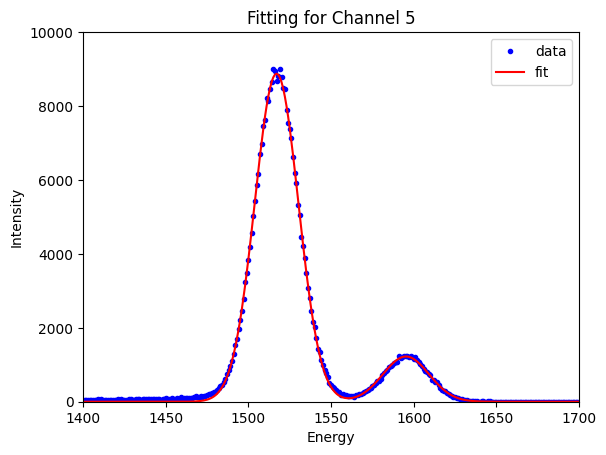

Peak 1: Mean = 1516.98, FWHM = 31.09
Peak 2: Mean = 1595.24, FWHM = 32.91
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 195
    # data points      = 16383
    # variables        = 6
    chi-square         = 2506599.76
    reduced chi-square = 153.056100
    Akaike info crit   = 82425.6694
    Bayesian info crit = 82471.8934
    R-squared          = 0.99879735
[[Variables]]
    g1_amplitude:  296453.920 +/- 99.2423688 (0.03%) (init = 8000)
    g1_center:     1486.65127 +/- 0.00467749 (0.00%) (init = 1520)
    g1_sigma:      12.1008176 +/- 0.00467786 (0.04%) (init = 15)
    g2_amplitude:  42732.0489 +/- 100.988789 (0.24%) (init = 3000)
    g2_center:     1562.02571 +/- 0.03419362 (0.00%) (init = 1600)
    g2_sigma:      12.5305012 +/- 0.03419641 (0.27%) (init = 10)
    g1_fwhm:       28.4952472 +/- 0.01101553 (0.04%) == '2.3548200*g1_sigma'
    g1_height:     9773.55523 +/- 3.2718

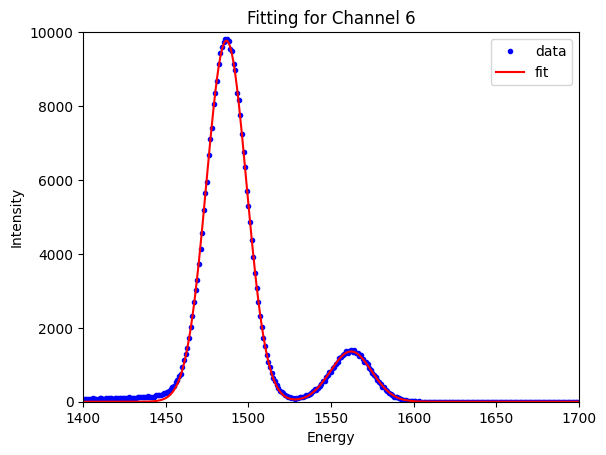

Peak 1: Mean = 1486.65, FWHM = 28.50
Peak 2: Mean = 1562.03, FWHM = 29.51


In [10]:
#IGNORE THIS FOR NOW
gmodel1 = GaussianModel(prefix='g1_')
gmodel2 = GaussianModel(prefix='g2_')

# Combined model
model = gmodel1 + gmodel2

# Initial parameters
params = model.make_params(g1_center=1520, g1_sigma=15, g1_amplitude=8000,
                           g2_center=1600, g2_sigma=10, g2_amplitude=3000)
fwhm_0 = []
mean_1 = []
mean_2 = []
#i=0
for name, data in spectnames.items():

    #if i==1: break # only channel 0
# Fit the model
    x = np.arange(len(data))
    result = model.fit(data, params, x=x)

# Print the fitting results
    print(result.fit_report())

# Plotting
    plt.plot(x, data, 'b.', label='data')
    plt.plot(x, result.best_fit, 'r-', label='fit')
    plt.xlabel('Energy')
    plt.ylabel('Intensity')
    plt.title('Fitting for ' +  name)
    #plt.yscale('log')
    plt.xlim([1400, 1700])
    plt.ylim([0, 10000])
    plt.legend()
    save_current_plot('gaussfit_ch0.png')
    plt.show()
    

# Extracting the means and FWHMs
    mean1 = result.params['g1_center'].value
    mean2 = result.params['g2_center'].value
    fwhm1 = result.params['g1_sigma'].value * 2 * np.sqrt(2 * np.log(2))
    fwhm2 = result.params['g2_sigma'].value * 2 * np.sqrt(2 * np.log(2))

    mean_1.append(mean1)
    mean_2.append(mean2)

    print(f'Peak 1: Mean = {mean1:.2f}, FWHM = {fwhm1:.2f}')
    print(f'Peak 2: Mean = {mean2:.2f}, FWHM = {fwhm2:.2f}')
    #i+=1
    

In [20]:
1515.92/5.9

256.935593220339*6.49

1667.5120000000002

In [11]:

#mean_values_Kα_LSB = [1515.92, 1527.73, 1516.19, 1536.71, 1517.00, 1516.98, 1486.65]  
#mean_values_Kβ_LSB = [1593.03, 1604.07, 1594.17, 1616.31, 1594.30, 1595.24, 1562.03]  

# True energy values in keV
E_Kα = 5.90
E_Kβ = 6.49

# Storage for slope (a) and intercept (b) for each dataset
a_values = []
b_values = []

# Loop through each set of mean values
for i in range(len(mean_1)):
    mean_Kα_LSB = mean_1[i]
    mean_Kβ_LSB = mean_2[i]

    # Construct the matrices for the linear equations
    A = np.array([[mean_Kα_LSB, 1], [mean_Kβ_LSB, 1]])
    B = np.array([E_Kα, E_Kβ])

    # Solve for a and b
    a, b = np.linalg.solve(A, B)
    
    # Store the results
    a_values.append(a)
    b_values.append(b)
    
    print(f"Dataset {i+1}:")
    print(f"  Slope (a): {a} keV/LSB")
    print(f"  Intercept (b): {b} keV/n")




Dataset 1:
  Slope (a): 0.007651803132934968 keV/LSB
  Intercept (b): -5.699548221623876 keV/n
Dataset 2:
  Slope (a): 0.007728470308971276 keV/LSB
  Intercept (b): -5.907014643679188 keV/n
Dataset 3:
  Slope (a): 0.007566133141839505 keV/LSB
  Intercept (b): -5.57166547805058 keV/n
Dataset 4:
  Slope (a): 0.007411981716283826 keV/LSB
  Intercept (b): -5.490052397715568 keV/n
Dataset 5:
  Slope (a): 0.0076326988813804775 keV/LSB
  Intercept (b): -5.678810620428145 keV/n
Dataset 6:
  Slope (a): 0.0075384526299817544 keV/LSB
  Intercept (b): -5.535676518962938 keV/n
Dataset 7:
  Slope (a): 0.007827587414285117 keV/LSB
  Intercept (b): -5.736892782532243 keV/n


In [22]:
#error calc -> the error is 0 when you fit 2 points with a line
res = []

for i in range(len(mean_values_Kβ_LSB)):
    hue = mean_values_Kβ_LSB[i]*a_values[i] + b_values[i]
    r = hue - 6.49
    err = abs(r)/6.49
    print(err)

0.0
0.0
0.0
1.368533774576464e-16
0.0
1.368533774576464e-16
0.0


In [12]:
x0 = np.arange(len(s_0))
x1 = np.arange(len(s_1))
x2 = np.arange(len(s_2))
x3 = np.arange(len(s_3))
x4 = np.arange(len(s_4))
x5 = np.arange(len(s_5))
x6 = np.arange(len(s_6))


cs_00 = a_values[0]*x0 + b_values[0]
cs_01 = a_values[1]*x1 + b_values[1]
cs_02 = a_values[2]*x2 + b_values[2]
cs_03 = a_values[3]*x3 +b_values[3]
cs_04 = a_values[4]*x4 + b_values[4]
cs_05 = a_values[5]*x5 + b_values[5]
cs_06 = a_values[6]*x6 + b_values[6]

# x0 = (cs_00 - b_values[0])/a_values[0]
# x1 = (cs_01 - b_values[1])/a_values[1]
# x2 = (cs_02 - b_values[2])/a_values[2]
# x3 = (cs_03 - b_values[3])/a_values[3]
# x4 = (cs_04 - b_values[4])/a_values[4]
# x5 = (cs_05 - b_values[5])/a_values[5]
# x6 = (cs_06 - b_values[6])/a_values[6]

csnames = {'cs_00':cs_00,
'cs_01':cs_01,
'cs_02':cs_02,
'cs_03':cs_03,
'cs_04':cs_04,
'cs_05':cs_05,
'cs_06':cs_06}

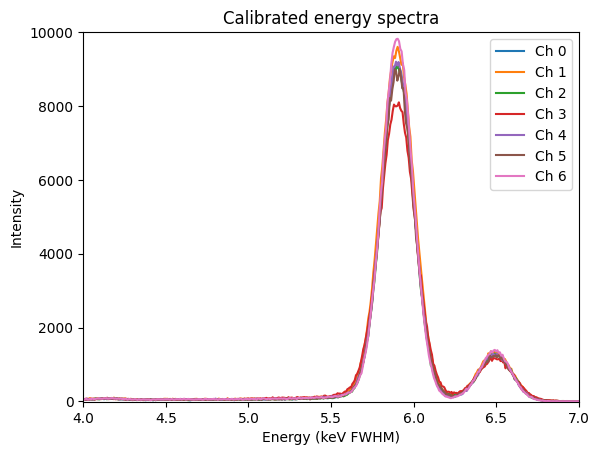

In [14]:
plt.plot(cs_00, s_0, label='Ch 0')  # Plot only the first 1000 points
plt.plot(cs_01, s_1, label='Ch 1')
plt.plot(cs_02, s_2, label='Ch 2')
plt.plot(cs_03, s_3, label='Ch 3')
plt.plot(cs_04, s_4, label='Ch 4')
plt.plot(cs_05, s_5, label='Ch 5')
plt.plot(cs_06, s_6, label='Ch 6')

plt.xlabel('Energy (keV FWHM)')
plt.ylabel('Intensity')
plt.xlim([4, 7])
plt.ylim([-10, 10000])
plt.legend()
plt.title('Calibrated energy spectra')
save_current_plot("combined_cal_spectra.png")

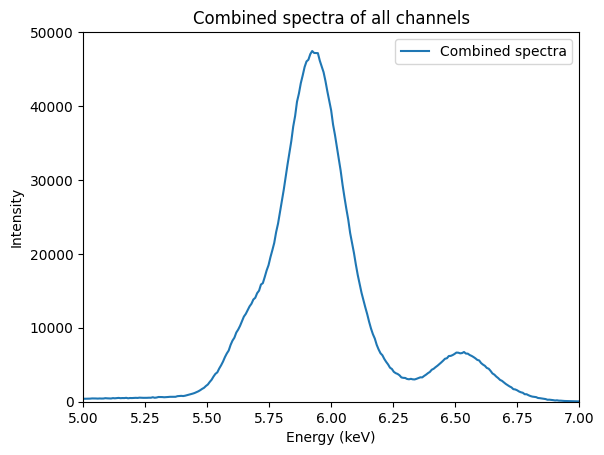

In [17]:
#combination of all channels
totalspect = s_0 + s_1 + s_2 + s_3 + s_4 + s_5 + s_6

plt.plot(cs_00, totalspect, label = 'Combined spectra')
plt.xlim([5, 7])
plt.ylim([-10, 50000])

plt.xlabel('Energy (keV)')
plt.ylabel('Intensity')
plt.legend()
plt.title('Combined spectra of all channels')
save_current_plot("sum_spectra.png")

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 299
    # data points      = 16383
    # variables        = 6
    chi-square         = 8.5099e+11
    reduced chi-square = 51962701.5
    Akaike info crit   = 291066.979
    Bayesian info crit = 291113.203
    R-squared          = 0.07126123
[[Variables]]
    g1_amplitude:  20274.7750 +/- 3077.61479 (15.18%) (init = 48000)
    g1_center:     5.88324636 +/- 0.01972440 (0.34%) (init = 5.92)
    g1_sigma:      0.15380538 +/- 0.00768419 (5.00%) (init = 0.5)
    g2_amplitude: -3818.70440 +/- 2974.17192 (77.88%) (init = 6700)
    g2_center:     5.78158879 +/- 0.01806969 (0.31%) (init = 6.5)
    g2_sigma:      0.07996645 +/- 0.02542698 (31.80%) (init = 0.3075)
    g1_fwhm:       0.36218397 +/- 0.01809488 (5.00%) == '2.3548200*g1_sigma'
    g1_height:     52588.9641 +/- 8154.90626 (15.51%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
   

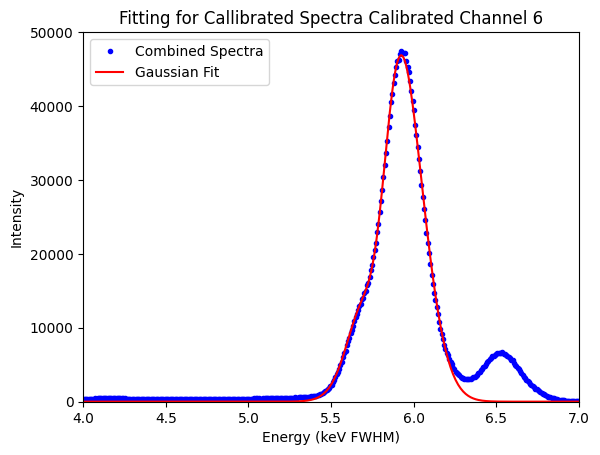

Peak 1: Mean = 5.88, FWHM = 0.36
Peak 2: Mean = 5.78, FWHM = 0.19


In [55]:
#FWHMs for calibrated spectra
gmodel111 = GaussianModel(prefix='g1_')
gmodel211 = GaussianModel(prefix='g2_')

# Combined model
model1 = gmodel111 + gmodel211
# Initial parameters
paramets = model1.make_params(g1_center=5.92, g1_sigma=0.5, g1_amplitude=48000,
                           g2_center=6.5, g2_sigma=0.3075, g2_amplitude=6700)

x = cs_00
#offset_totalspect = totalspect + 40
result = model.fit(totalspect, paramets, x=x)

# Print the fitting results
print(result.fit_report())

# Plotting
plt.plot(cs_00, totalspect, 'b.', label='Combined Spectra')
plt.plot(cs_00, result.best_fit, 'r-', label='Gaussian Fit')
plt.xlabel('Energy (keV FWHM)')
plt.ylabel('Intensity')
plt.title('Fitting for Callibrated Spectra ' +  name)
plt.xlim([4, 7])
#plt.yscale('log')
plt.ylim([-10, 50000])
plt.legend()
plt.show()

# Extracting the means and FWHMs
mean1 = result.params['g1_center'].value
mean2 = result.params['g2_center'].value
fwhm1 = result.params['g1_sigma'].value * 2 * np.sqrt(2 * np.log(2))
fwhm2 = result.params['g2_sigma'].value * 2 * np.sqrt(2 * np.log(2))

print(f'Peak 1: Mean = {mean1:.2f}, FWHM = {fwhm1:.2f}')
print(f'Peak 2: Mean = {mean2:.2f}, FWHM = {fwhm2:.2f}')

0.29


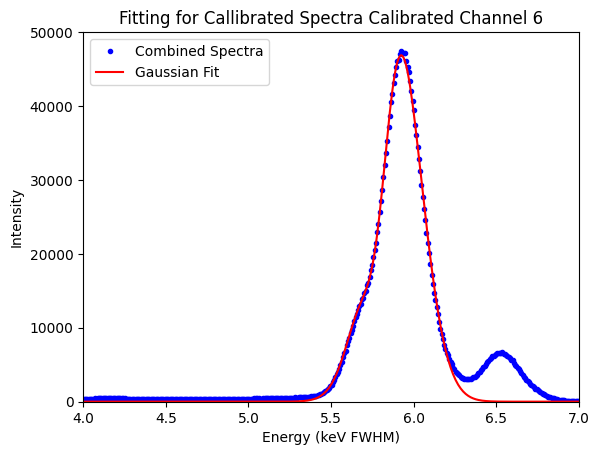

Peak 1: Mean = 5.88, FWHM = 0.36
Peak 2: Mean = 5.78, FWHM = 0.19
0.291


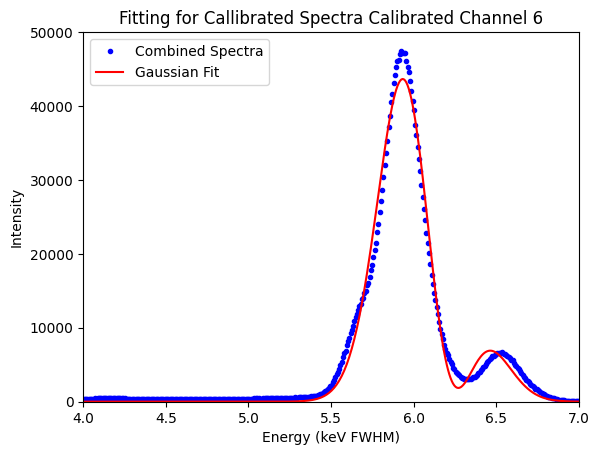

Peak 1: Mean = 6.12, FWHM = 0.47
Peak 2: Mean = 6.16, FWHM = 0.41
0.292


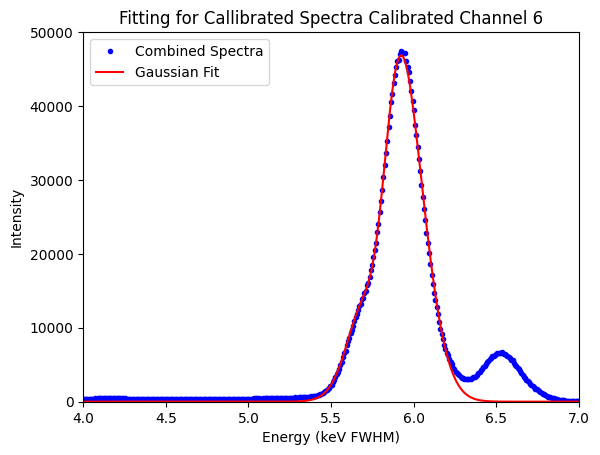

Peak 1: Mean = 5.88, FWHM = 0.36
Peak 2: Mean = 5.78, FWHM = 0.19
0.293


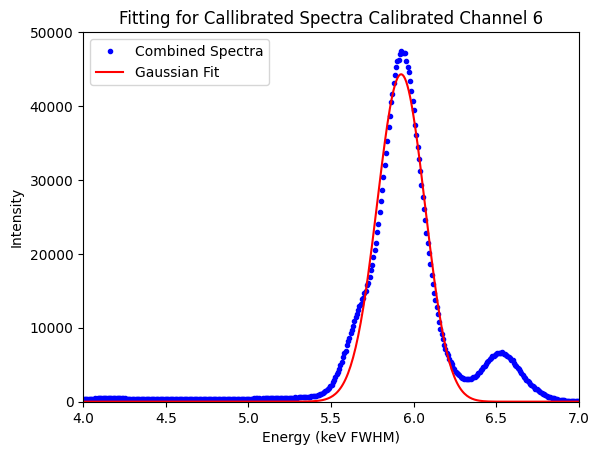

Peak 1: Mean = 5.95, FWHM = 0.35
Peak 2: Mean = 5.96, FWHM = 0.35
0.294


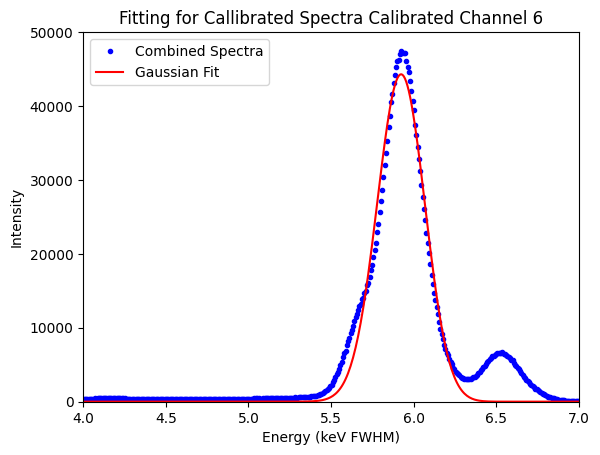

Peak 1: Mean = 5.95, FWHM = 0.35
Peak 2: Mean = 5.96, FWHM = 0.35
0.295


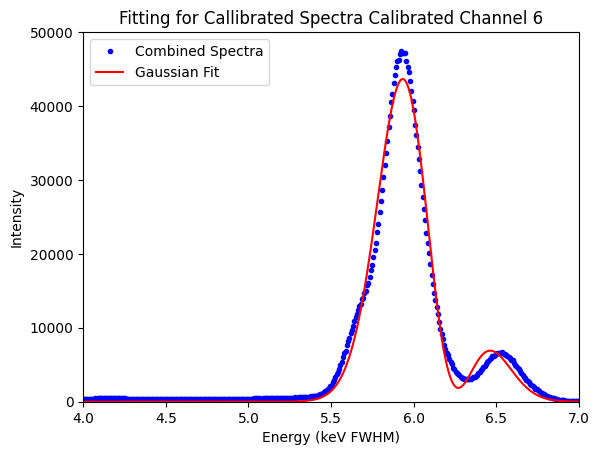

Peak 1: Mean = 6.12, FWHM = 0.47
Peak 2: Mean = 6.16, FWHM = 0.41
0.296


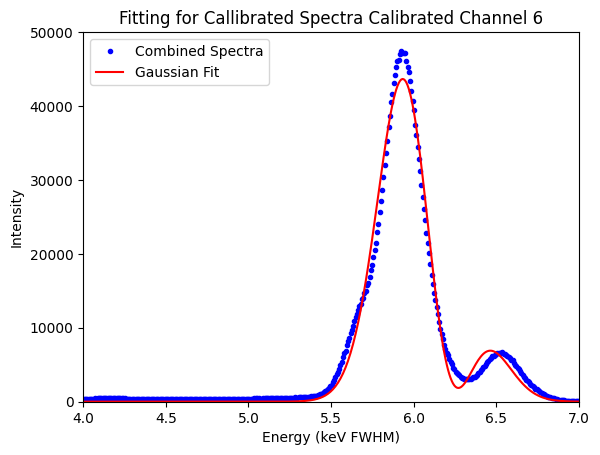

Peak 1: Mean = 6.12, FWHM = 0.47
Peak 2: Mean = 6.16, FWHM = 0.41
0.297


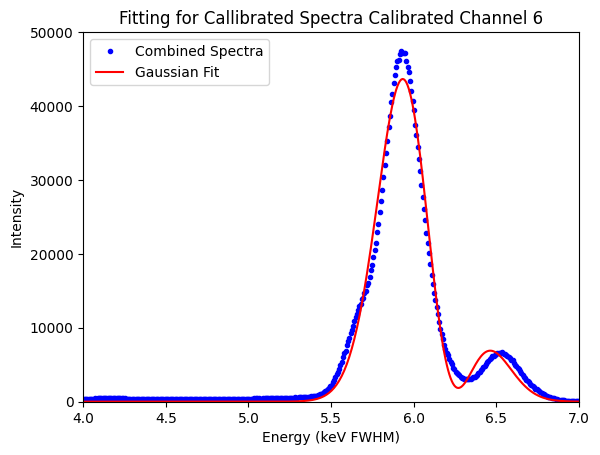

Peak 1: Mean = 6.12, FWHM = 0.47
Peak 2: Mean = 6.16, FWHM = 0.41
0.298


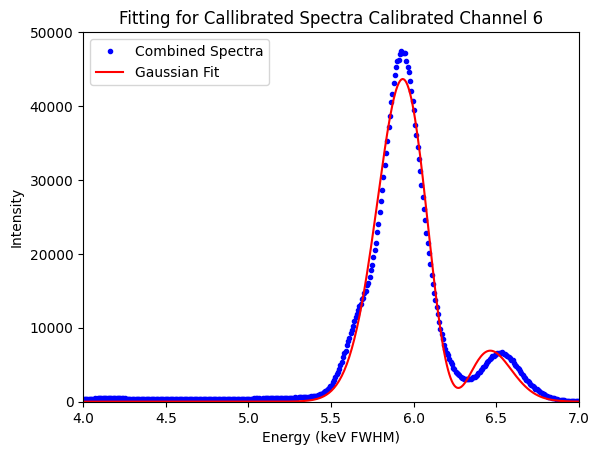

Peak 1: Mean = 6.12, FWHM = 0.47
Peak 2: Mean = 6.16, FWHM = 0.41
0.299


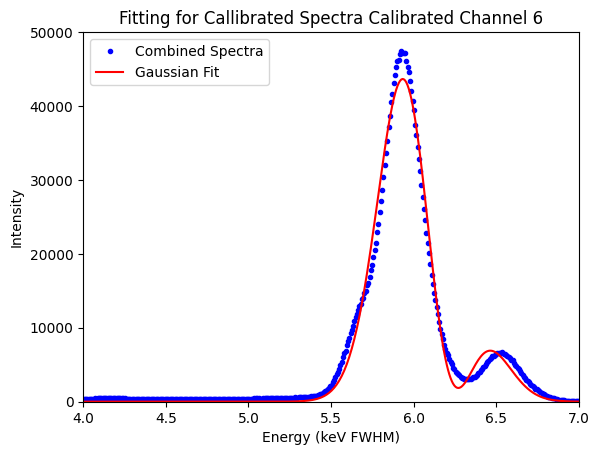

Peak 1: Mean = 6.12, FWHM = 0.47
Peak 2: Mean = 6.16, FWHM = 0.41
0.3


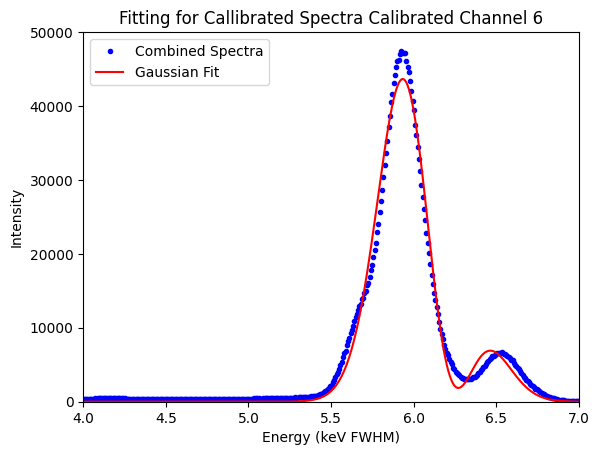

Peak 1: Mean = 6.12, FWHM = 0.47
Peak 2: Mean = 6.16, FWHM = 0.41
0.301


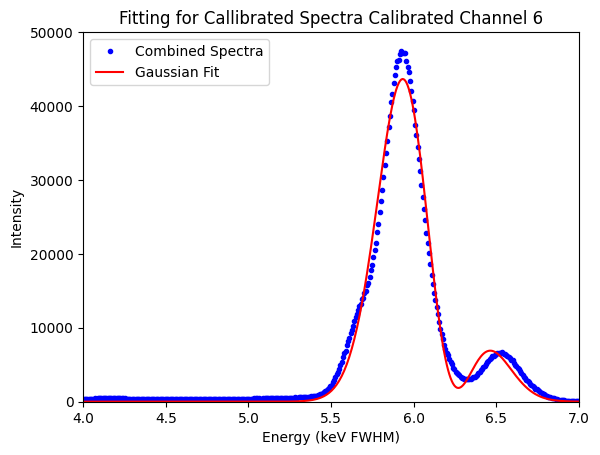

Peak 1: Mean = 6.12, FWHM = 0.47
Peak 2: Mean = 6.16, FWHM = 0.41
0.302


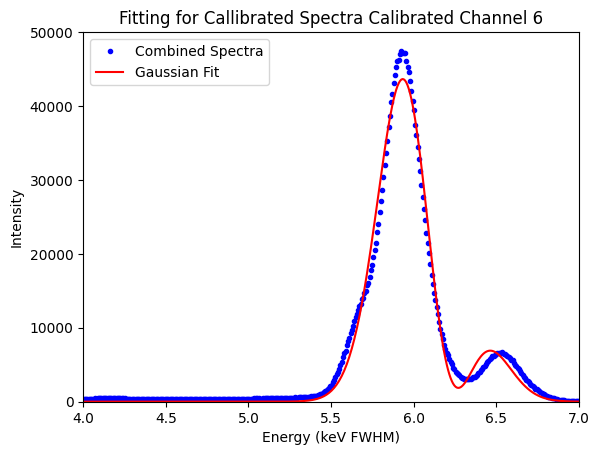

Peak 1: Mean = 6.12, FWHM = 0.47
Peak 2: Mean = 6.16, FWHM = 0.41
0.303


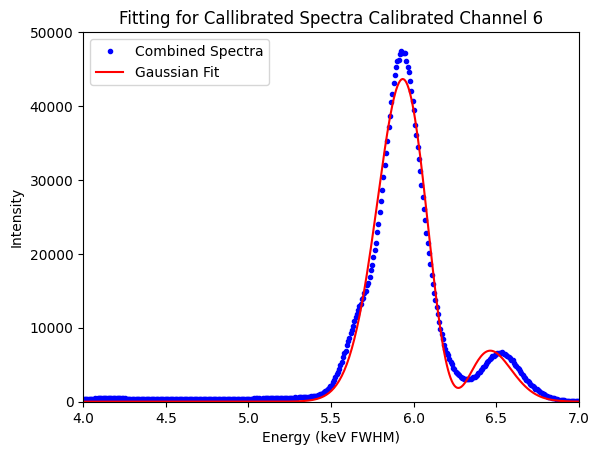

Peak 1: Mean = 6.12, FWHM = 0.47
Peak 2: Mean = 6.16, FWHM = 0.41
0.304


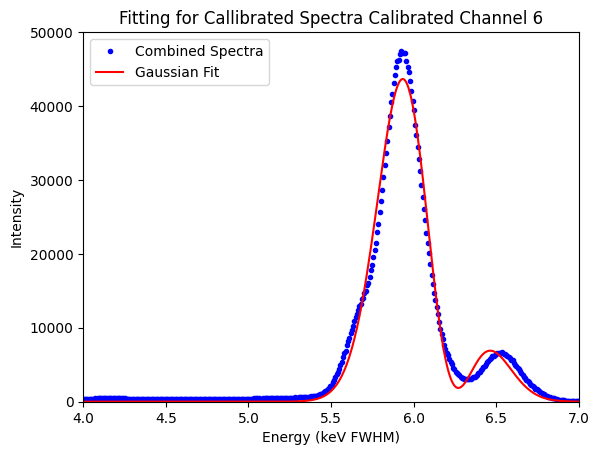

Peak 1: Mean = 6.12, FWHM = 0.47
Peak 2: Mean = 6.16, FWHM = 0.41
0.305


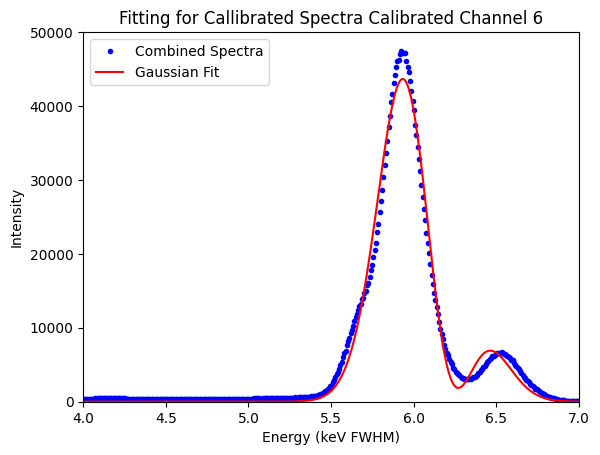

Peak 1: Mean = 6.12, FWHM = 0.47
Peak 2: Mean = 6.16, FWHM = 0.41
0.306


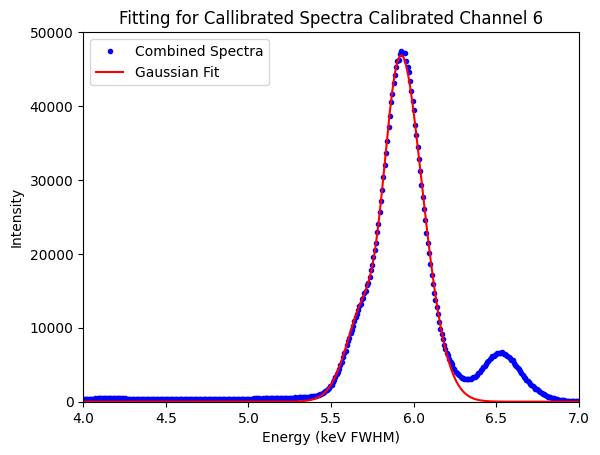

Peak 1: Mean = 5.88, FWHM = 0.36
Peak 2: Mean = 5.78, FWHM = 0.19
0.307


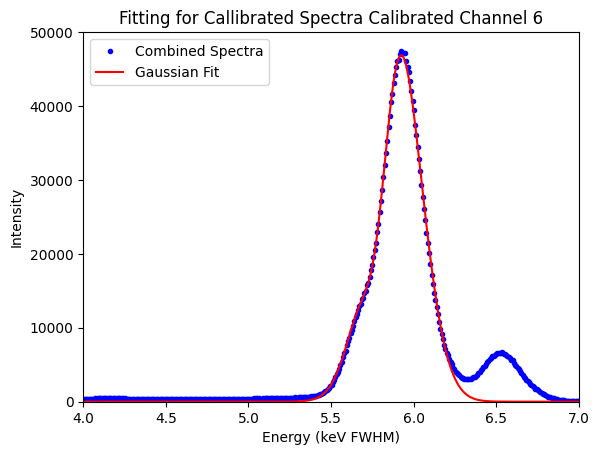

Peak 1: Mean = 5.88, FWHM = 0.36
Peak 2: Mean = 5.78, FWHM = 0.19
0.308


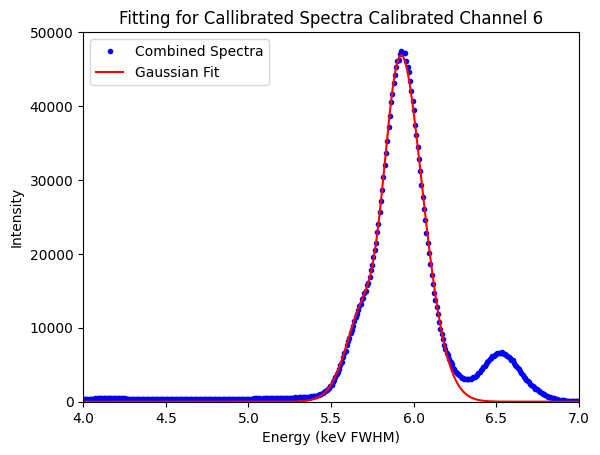

Peak 1: Mean = 5.88, FWHM = 0.36
Peak 2: Mean = 5.78, FWHM = 0.19
0.309


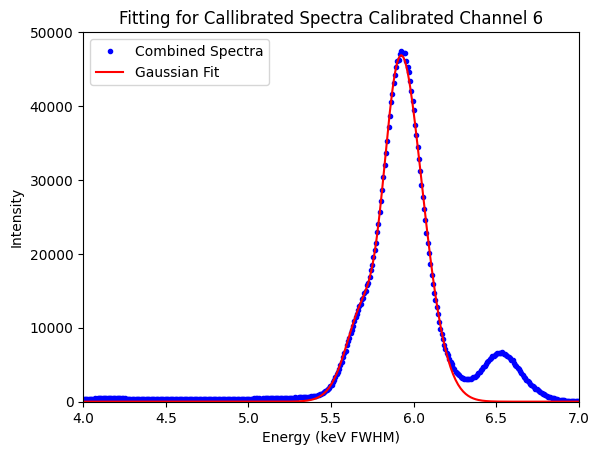

Peak 1: Mean = 5.88, FWHM = 0.36
Peak 2: Mean = 5.78, FWHM = 0.19
0.31


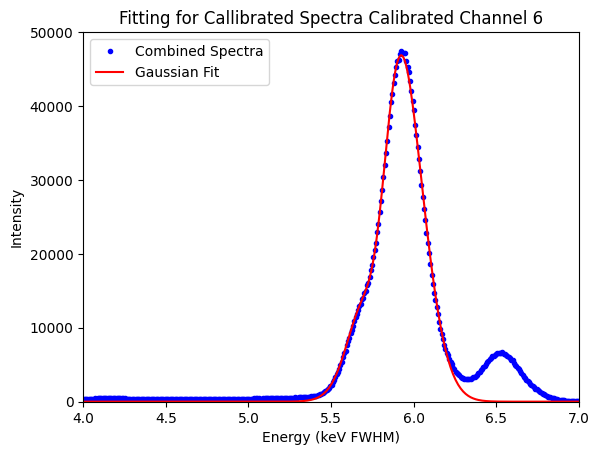

Peak 1: Mean = 5.88, FWHM = 0.36
Peak 2: Mean = 5.78, FWHM = 0.19
0.311


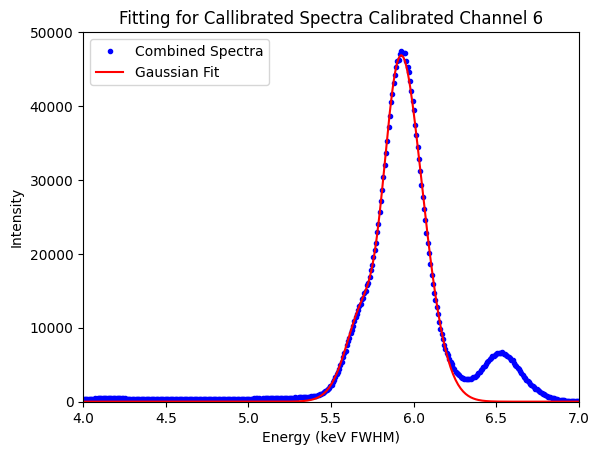

Peak 1: Mean = 5.88, FWHM = 0.36
Peak 2: Mean = 5.78, FWHM = 0.19
0.312


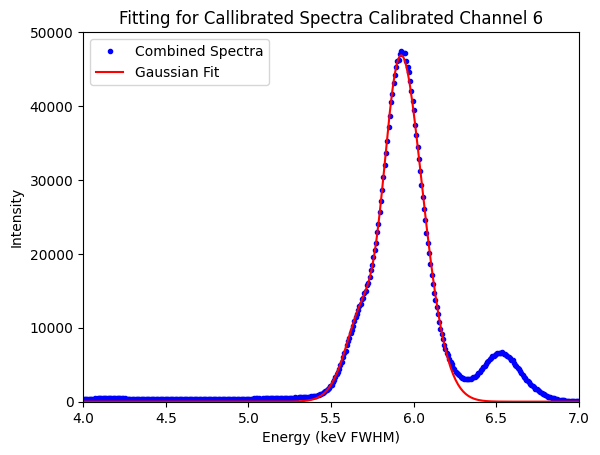

Peak 1: Mean = 5.88, FWHM = 0.36
Peak 2: Mean = 5.78, FWHM = 0.19
0.313


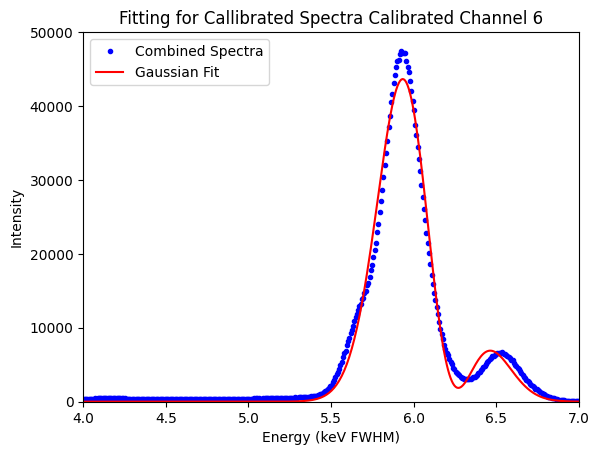

Peak 1: Mean = 6.12, FWHM = 0.47
Peak 2: Mean = 6.16, FWHM = 0.41
0.314


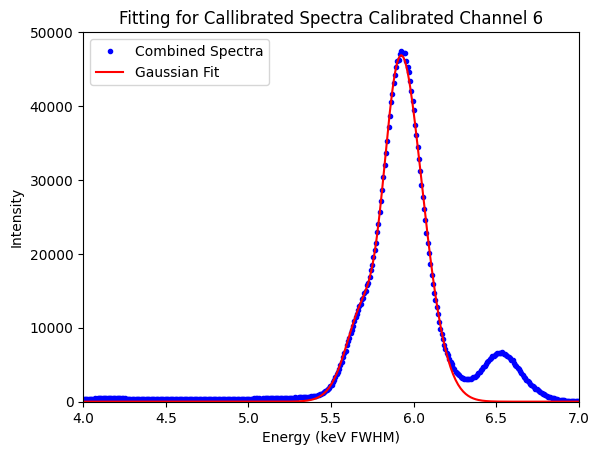

Peak 1: Mean = 5.88, FWHM = 0.36
Peak 2: Mean = 5.78, FWHM = 0.19
0.315


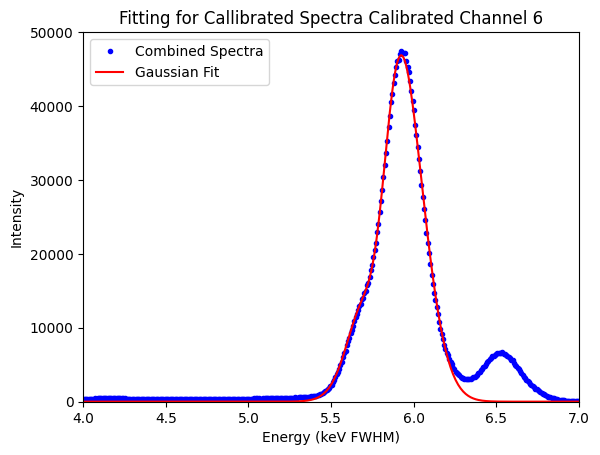

Peak 1: Mean = 5.88, FWHM = 0.36
Peak 2: Mean = 5.78, FWHM = 0.19
0.316


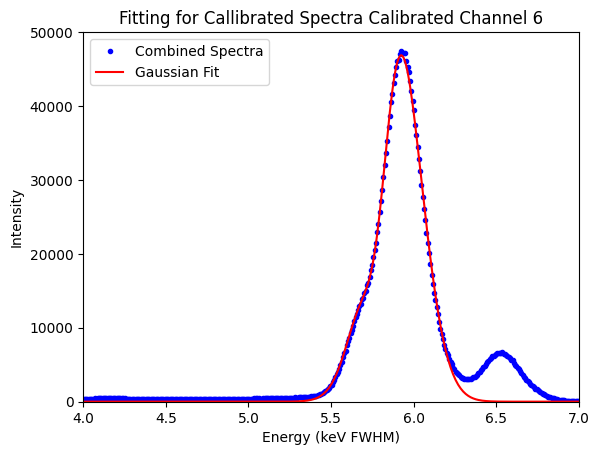

Peak 1: Mean = 5.88, FWHM = 0.36
Peak 2: Mean = 5.78, FWHM = 0.19


In [64]:
#FWHMs for calibrated spectra
gmodel111 = GaussianModel(prefix='g1_')
gmodel211 = GaussianModel(prefix='g2_')

# Combined model
model1 = gmodel111 + gmodel211
# Initial parameters
#g2_width = 0.3
for g2_width in np.arange(0.29, 0.315 + 0.001, 0.001):
    paramets = model1.make_params(g1_center=5.92, g1_sigma=0.5, g1_amplitude=48000,
                           g2_center=6.5, g2_sigma=g2_width, g2_amplitude=6800)

    x = cs_00
    #offset_totalspect = totalspect + 40
    result = model.fit(totalspect, paramets, x=x)

# Print the fitting results
#print(result.fit_report())
    print(g2_width)
    # Plotting
    plt.plot(cs_00, totalspect, 'b.', label='Combined Spectra')
    plt.plot(cs_00, result.best_fit, 'r-', label='Gaussian Fit')
    plt.xlabel('Energy (keV FWHM)')
    plt.ylabel('Intensity')
    plt.title('Fitting for Callibrated Spectra ' +  name)
    plt.xlim([4, 7])
    #plt.yscale('log')
    plt.ylim([-10, 50000])
    plt.legend()
    plt.show()

    # Extracting the means and FWHMs
    mean1 = result.params['g1_center'].value
    mean2 = result.params['g2_center'].value
    fwhm1 = result.params['g1_sigma'].value * 2 * np.sqrt(2 * np.log(2))
    fwhm2 = result.params['g2_sigma'].value * 2 * np.sqrt(2 * np.log(2))

    print(f'Peak 1: Mean = {mean1:.2f}, FWHM = {fwhm1:.2f}')
    print(f'Peak 2: Mean = {mean2:.2f}, FWHM = {fwhm2:.2f}')
    g2_width =+ 0.005

In [19]:
cal_chan0 = list(zip(cs_00, s_0))
cal_chan1 = list(zip(cs_01, s_1))
cal_chan2 = list(zip(cs_02, s_2))
cal_chan3 = list(zip(cs_03, s_3))
cal_chan4 = list(zip(cs_04, s_4))
cal_chan5 = list(zip(cs_05, s_5))
cal_chan6 = list(zip(cs_06, s_6))

cal_chan = {'Calibrated Channel 0':cal_chan0,
            'Calibrated Channel 1':cal_chan1,
            'Calibrated Channel 2':cal_chan2,
            'Calibrated Channel 3':cal_chan3,
            'Calibrated Channel 4':cal_chan4,
            'Calibrated Channel 5':cal_chan5,
            'Calibrated Channel 6':cal_chan6}

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 152
    # data points      = 16383
    # variables        = 6
    chi-square         = 2138962.43
    reduced chi-square = 130.607707
    Akaike info crit   = 79827.2225
    Bayesian info crit = 79873.4465
    R-squared          = 0.99889330
[[Variables]]
    g1_amplitude:  2262.61703 +/- 0.72657546 (0.03%) (init = 8000)
    g1_center:     5.90000000 +/- 3.6819e-05 (0.00%) (init = 5.9)
    g1_sigma:      0.09930775 +/- 3.6831e-05 (0.04%) (init = 0.5)
    g2_amplitude:  328.806344 +/- 0.74657390 (0.23%) (init = 1500)
    g2_center:     6.48999984 +/- 2.7487e-04 (0.00%) (init = 6.04)
    g2_sigma:      0.10485103 +/- 2.7496e-04 (0.26%) (init = 1)
    g1_fwhm:       0.23385187 +/- 8.6731e-05 (0.04%) == '2.3548200*g1_sigma'
    g1_height:     9089.45842 +/- 2.91858992 (0.03%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_fwhm: 

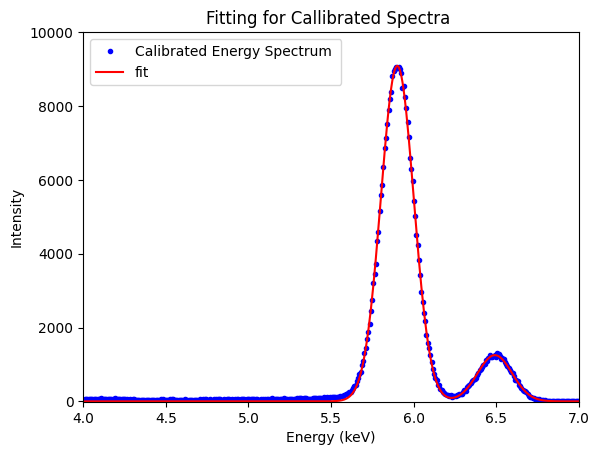

Peak 1: Mean = 5.90, FWHM = 0.23
Peak 2: Mean = 6.49, FWHM = 0.25
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 125
    # data points      = 16383
    # variables        = 6
    chi-square         = 2784343.06
    reduced chi-square = 170.015452
    Akaike info crit   = 84147.2737
    Bayesian info crit = 84193.4977
    R-squared          = 0.99871375
[[Variables]]
    g1_amplitude:  2443.25442 +/- 0.84604198 (0.03%) (init = 8000)
    g1_center:     5.90000000 +/- 4.0933e-05 (0.00%) (init = 5.9)
    g1_sigma:      0.10238963 +/- 4.0954e-05 (0.04%) (init = 0.5)
    g2_amplitude:  353.544209 +/- 0.86162462 (0.24%) (init = 1500)
    g2_center:     6.49000003 +/- 2.9880e-04 (0.00%) (init = 6.04)
    g2_sigma:      0.10619886 +/- 2.9896e-04 (0.28%) (init = 1)
    g1_fwhm:       0.24110915 +/- 9.6440e-05 (0.04%) == '2.3548200*g1_sigma'
    g1_height:     9519.68987 +/- 3.29599034 (0.0

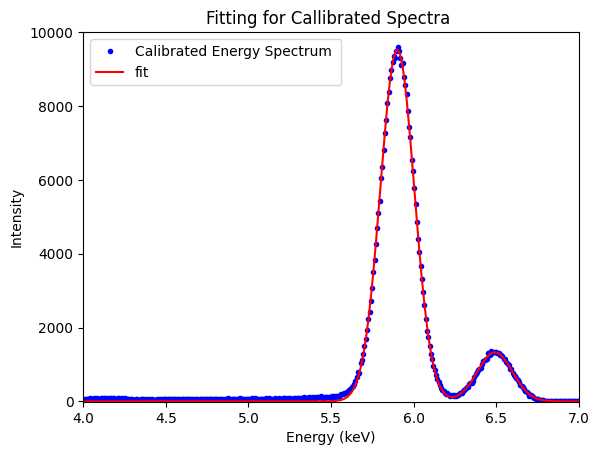

Peak 1: Mean = 5.90, FWHM = 0.24
Peak 2: Mean = 6.49, FWHM = 0.25
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 130
    # data points      = 16383
    # variables        = 6
    chi-square         = 2149111.59
    reduced chi-square = 131.227428
    Akaike info crit   = 79904.7744
    Bayesian info crit = 79950.9984
    R-squared          = 0.99887333
[[Variables]]
    g1_amplitude:  2218.80278 +/- 0.71897722 (0.03%) (init = 8000)
    g1_center:     5.90000000 +/- 3.6620e-05 (0.00%) (init = 5.9)
    g1_sigma:      0.09788104 +/- 3.6631e-05 (0.04%) (init = 0.5)
    g2_amplitude:  327.653593 +/- 0.74643584 (0.23%) (init = 1500)
    g2_center:     6.48999984 +/- 2.7750e-04 (0.00%) (init = 6.04)
    g2_sigma:      0.10550171 +/- 2.7758e-04 (0.26%) (init = 1)
    g1_fwhm:       0.23049224 +/- 8.6260e-05 (0.04%) == '2.3548200*g1_sigma'
    g1_height:     9043.36792 +/- 2.93018319 (0.0

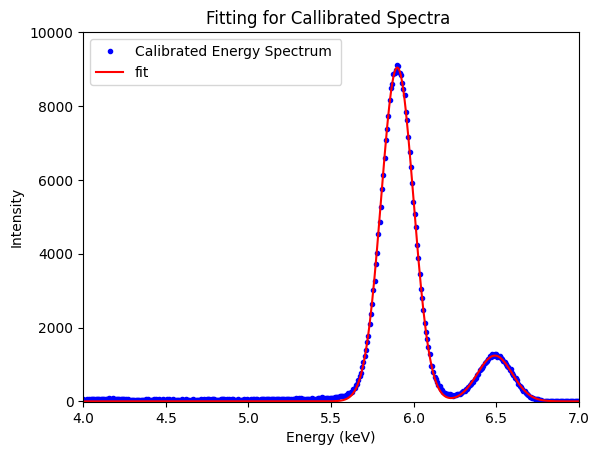

Peak 1: Mean = 5.90, FWHM = 0.23
Peak 2: Mean = 6.49, FWHM = 0.25
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14000
    # data points      = 16383
    # variables        = 6
    chi-square         = 38421456.4
    reduced chi-square = 2346.06194
    Akaike info crit   = 127146.163
    Bayesian info crit = 127192.387
    R-squared          = 0.99981923
##  Warning: uncertainties could not be estimated:
[[Variables]]
    g1_amplitude:  2170.75108 (init = 8000)
    g1_center:     5.90007505 (init = 5.9)
    g1_sigma:      0.10780723 (init = 0.5)
    g2_amplitude:  474562.771 (init = 1500)
    g2_center:    -5.50083342 (init = 6.04)
    g2_sigma:      0.00348988 (init = 1)
    g1_fwhm:       0.25386662 == '2.3548200*g1_sigma'
    g1_height:     8032.89766 == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_fwhm:       0.00821804 == '2.3548200*g2_sigma'
    g2_height:     54249

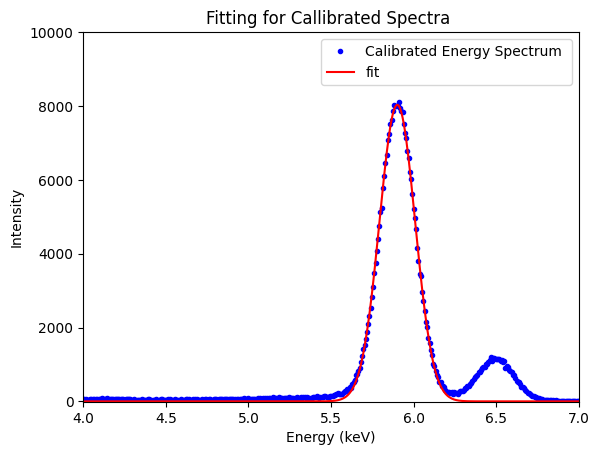

Peak 1: Mean = 5.90, FWHM = 0.25
Peak 2: Mean = -5.50, FWHM = 0.01
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 130
    # data points      = 16383
    # variables        = 6
    chi-square         = 2453119.02
    reduced chi-square = 149.790500
    Akaike info crit   = 82072.3393
    Bayesian info crit = 82118.5633
    R-squared          = 0.99873755
[[Variables]]
    g1_amplitude:  2251.88435 +/- 0.77235492 (0.03%) (init = 8000)
    g1_center:     5.90000000 +/- 3.8850e-05 (0.00%) (init = 5.9)
    g1_sigma:      0.09810207 +/- 3.8858e-05 (0.04%) (init = 0.5)
    g2_amplitude:  325.937382 +/- 0.78976897 (0.24%) (init = 1500)
    g2_center:     6.49000003 +/- 2.8699e-04 (0.00%) (init = 6.04)
    g2_sigma:      0.10257768 +/- 2.8704e-04 (0.28%) (init = 1)
    g1_fwhm:       0.23101271 +/- 9.1504e-05 (0.04%) == '2.3548200*g1_sigma'
    g1_height:     9157.52271 +/- 3.14070854 (0.

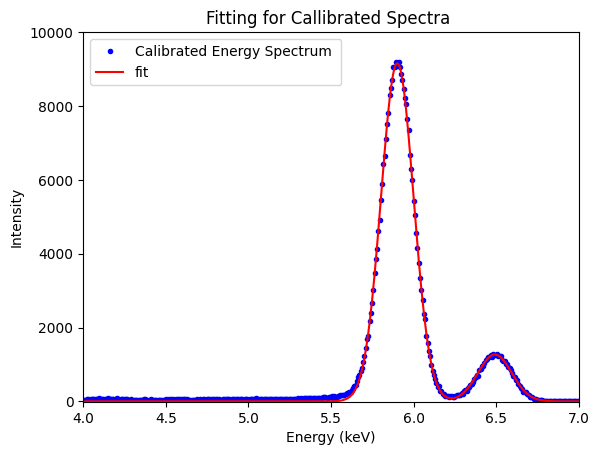

Peak 1: Mean = 5.90, FWHM = 0.23
Peak 2: Mean = 6.49, FWHM = 0.24
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14000
    # data points      = 16383
    # variables        = 6
    chi-square         = 5.5088e+08
    reduced chi-square = 33637.5901
    Akaike info crit   = 170772.552
    Bayesian info crit = 170818.776
    R-squared          = 0.99740850
##  Warning: uncertainties could not be estimated:
    g1_center:     at initial value
[[Variables]]
    g1_amplitude:  2214.96079 (init = 8000)
    g1_center:     5.90001992 (init = 5.9)
    g1_sigma:      0.09958253 (init = 0.5)
    g2_amplitude:  585400.249 (init = 1500)
    g2_center:    -5.54699840 (init = 6.04)
    g2_sigma:      0.00361734 (init = 1)
    g1_fwhm:       0.23449892 == '2.3548200*g1_sigma'
    g1_height:     8873.45987 == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_fwhm:       0.00851819 == '2.354820

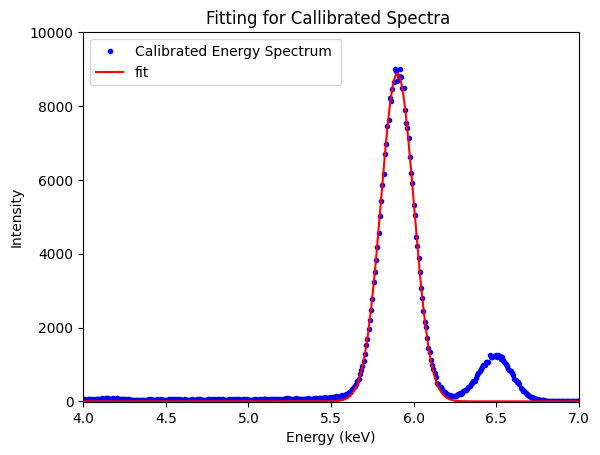

Peak 1: Mean = 5.90, FWHM = 0.23
Peak 2: Mean = -5.55, FWHM = 0.01
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 165
    # data points      = 16383
    # variables        = 6
    chi-square         = 2506599.76
    reduced chi-square = 153.056100
    Akaike info crit   = 82425.6694
    Bayesian info crit = 82471.8934
    R-squared          = 0.99879735
[[Variables]]
    g1_amplitude:  2320.51909 +/- 0.77682997 (0.03%) (init = 8000)
    g1_center:     5.90000000 +/- 3.6613e-05 (0.00%) (init = 5.9)
    g1_sigma:      0.09472022 +/- 3.6617e-05 (0.04%) (init = 0.5)
    g2_amplitude:  334.489081 +/- 0.79050676 (0.24%) (init = 1500)
    g2_center:     6.48999988 +/- 2.6766e-04 (0.00%) (init = 6.04)
    g2_sigma:      0.09808373 +/- 2.6767e-04 (0.27%) (init = 1)
    g1_fwhm:       0.22304906 +/- 8.6225e-05 (0.04%) == '2.3548200*g1_sigma'
    g1_height:     9773.55472 +/- 3.27180281 (0.

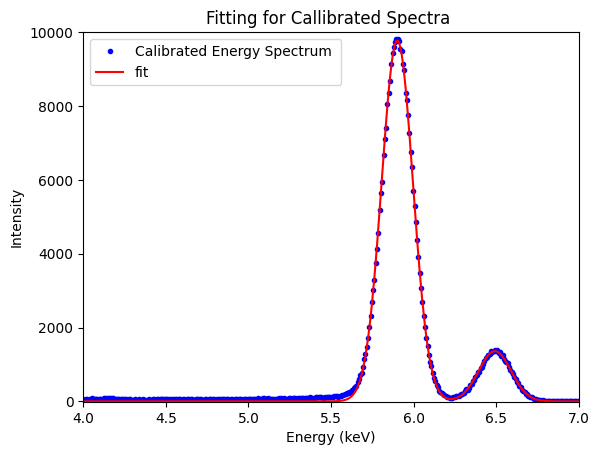

Peak 1: Mean = 5.90, FWHM = 0.22
Peak 2: Mean = 6.49, FWHM = 0.23
[0.23385187495639675, 0.24110915642192093, 0.23049224237979313, 0.2538666209180372, 0.2310127177878058, 0.2344989291937187, 0.2230490657974675]


In [20]:
#FWHMs for calibrated spectra
gmodel11 = GaussianModel(prefix='g1_')
gmodel21 = GaussianModel(prefix='g2_')

# Combined model
modell = gmodel11 + gmodel21
fwhm = []
# Initial parameters
parampa = modell.make_params(g1_center=5.9, g1_sigma=0.5, g1_amplitude=8000,
                           g2_center=6.04, g2_sigma=1, g2_amplitude=1500)

for name, data in cal_chan.items():
# Fit the model
    keV = [x for x, y in data]
    x = keV
    y = [y for x, y in data]
    result = model.fit(y, parampa, x=x)

# Print the fitting results
    print(result.fit_report())

# Plotting
    plt.plot(x, y, 'b.', label='Calibrated Energy Spectrum ')
    plt.plot(x, result.best_fit, 'r-', label='fit')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Intensity')
    plt.title('Fitting for Callibrated Spectra ')
    plt.xlim([4, 7])
    plt.ylim([-10, 10000])
    plt.legend()
    plt.show()

# Extracting the means and FWHMs
    mean1 = result.params['g1_center'].value
    mean2 = result.params['g2_center'].value
    fwhm1 = result.params['g1_sigma'].value * 2 * np.sqrt(2 * np.log(2))
    fwhm2 = result.params['g2_sigma'].value * 2 * np.sqrt(2 * np.log(2))

    print(f'Peak 1: Mean = {mean1:.2f}, FWHM = {fwhm1:.2f}')
    print(f'Peak 2: Mean = {mean2:.2f}, FWHM = {fwhm2:.2f}')

    fwhm.append(fwhm1)
    
    
print(fwhm)

Energy Resolutions across Channels


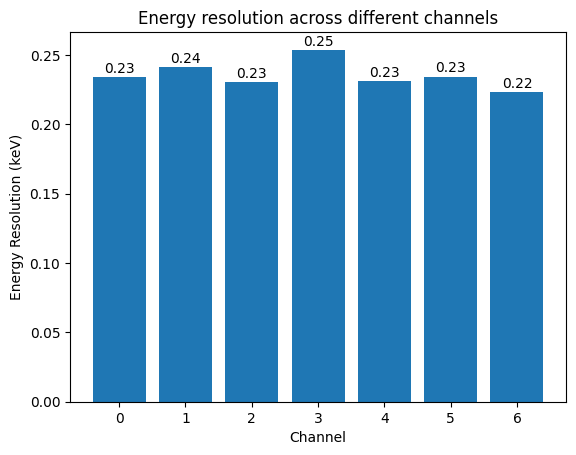

In [53]:
import pandas as pd

chan = [0, 1, 2, 3, 4, 5, 6]

bars = plt.bar(chan, fwhm)
plt.xlabel('Channel')
plt.ylabel('Energy Resolution (keV)')
#plt.ylim([28, 35])
for bar in bars:
    yval = bar.get_height()  # Get the height of the bar (y-value)
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f'{yval:.2f}', ha='center', va='bottom')

plt.title('Energy resolution across different channels')
save_current_plot("resolution_across_chan.png")

data = [chan], [fwhm]
df = pd.DataFrame(data)

# Plotting the table
df = pd.DataFrame([fwhm], columns=chan)
title = "Energy Resolutions across Channels"
print(title)
df
# Display the table
save_current_plot("resolution_across_chan_table.png")
plt.show()

### Noise analysis -> Acquisitions 2 to 8

In [54]:
time01 = np.loadtxt(path_to_data + "//run_07_08_2024_2//RAW//CH0@DT5725SB_13964_EspectrumR_run_07_08_2024_2_20240807_115252.txt")
time02 = np.loadtxt(path_to_data + "//run_07_08_2024_3//RAW//CH0@DT5725SB_13964_EspectrumR_run_07_08_2024_3_20240807_115512.txt")
time05 = np.loadtxt(path_to_data + "//run_07_08_2024_4//RAW//CH0@DT5725SB_13964_EspectrumR_run_07_08_2024_4_20240807_115650.txt")
time10 = np.loadtxt(path_to_data + "//run_07_08_2024_5//RAW//CH0@DT5725SB_13964_EspectrumR_run_07_08_2024_5_20240807_115844.txt")
time20 = np.loadtxt(path_to_data + "//run_07_08_2024_6//RAW//CH0@DT5725SB_13964_EspectrumR_run_07_08_2024_6_20240807_120026.txt")
time50 = np.loadtxt(path_to_data + "//run_07_08_2024_7//RAW//CH0@DT5725SB_13964_EspectrumR_run_07_08_2024_7_20240807_120149.txt")
time100 = np.loadtxt(path_to_data + "//run_07_08_2024_8//RAW//CH0@DT5725SB_13964_EspectrumR_run_07_08_2024_8_20240807_120312.txt")

In [55]:
time_trap_1000 = {
    'time_trap_0.1_µs':time01,
    'time_trap_0.2_µs':time02,
    'time_trap_0.5_µs':time05,
}

time_trap_1100 = {
    'time_trap_1.0_µs':time10
}

time_trap_1500 = {
    'time_trap_2.0_µs':time20}

time_trap_2500 = {
    'time_trap_5.0_µs':time50,
    'time_trap_10.0_µs':time100}

In [58]:
x01 = np.arange(len(time01))
x02 = np.arange(len(time02))
x05 = np.arange(len(time05))
x10 = np.arange(len(time10))
x20 = np.arange(len(time20))
x50 = np.arange(len(time50))
x100 = np.arange(len(time100))

x_trap_1000 = {
    'x_trap_0.1_µs':x01,
    'x_trap_0.2_µs':x02,
    'x_trap_0.5_µs':x05,
}

x_trap_1100 = {
    'x_trap_1.0_µs':x10
}

x_trap_1500 = {
    'x_trap_2.0_µs':x20}

time_trap_2500 = {
    'x_trap_5.0_µs':x50,
    'x_trap_10.0_µs':x100}

In [63]:
timetrap01 = list(zip(x01, time01))
timetrap02 = list(zip(x02, time02))
timetrap05 = list(zip(x05, time05))
timetrap10 = list(zip(x10, time10))
timetrap20 = list(zip(x20, time20))
timetrap50 = list(zip(x50, time50))
timetrap100 = list(zip(x100, time100))

cal_chan1000 = {'Time Trap 0.1µs':timetrap01,
            'Time Trap 0.2µs':timetrap02,
            'Time Trap 0.5µs':timetrap05}

cal_chan1100 = {'Time Trap 1.0µs':timetrap10}

cal_chan1500 = {'Time Trap 2.0µs':timetrap20}

cal_chan2500 = {'Time Trap 5.0µs':timetrap50,
            'Time Trap 10.0µs':timetrap100}

In [64]:
gmodel_new1 = GaussianModel(prefix='g1_')
gmodel_new2 = GaussianModel(prefix='g2_')

# Combined model_new
model_new = gmodel_new1 + gmodel_new2

FWHM_timetrap_precalibration = []
mean1_timetrap_precalibration = []
mean2_timetrap_precalibration = []

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 158
    # data points      = 16383
    # variables        = 6
    chi-square         = 32001.4327
    reduced chi-square = 1.95404730
    Akaike info crit   = 10981.0158
    Bayesian info crit = 11027.2398
    R-squared          = 0.99261328
[[Variables]]
    g1_amplitude:  7597.77093 +/- 55.0484601 (0.72%) (init = 350)
    g1_center:     1052.46116 +/- 0.48438668 (0.05%) (init = 1000)
    g1_sigma:      66.5413324 +/- 0.33069888 (0.50%) (init = 50)
    g2_amplitude:  15586.9222 +/- 48.6707907 (0.31%) (init = 30)
    g2_center:     1016.55950 +/- 0.03387963 (0.00%) (init = 1100)
    g2_sigma:      23.5153084 +/- 0.04475503 (0.19%) (init = 10)
    g1_fwhm:       156.692860 +/- 0.77873635 (0.50%) == '2.3548200*g1_sigma'
    g1_height:     45.5517211 +/- 0.41237194 (0.91%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_fwhm:   

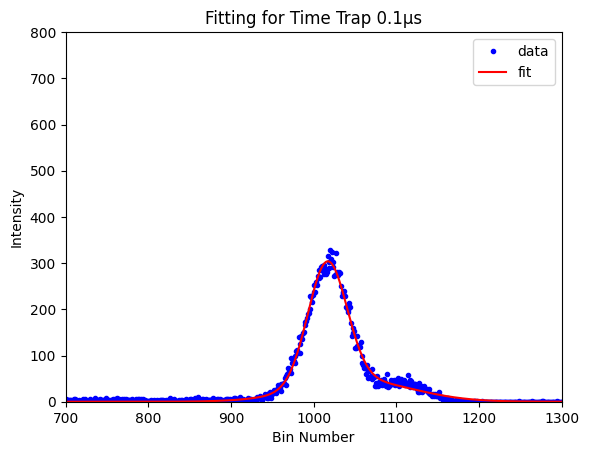

Peak 1: Mean = 1052.46, FWHM = 156.69
Peak 2: Mean = 1016.56, FWHM = 55.37
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 199
    # data points      = 16383
    # variables        = 6
    chi-square         = 22893.2211
    reduced chi-square = 1.39788857
    Akaike info crit   = 5493.69661
    Bayesian info crit = 5539.92061
    R-squared          = 0.99587078
[[Variables]]
    g1_amplitude:  2813.52641 +/- 12.5952445 (0.45%) (init = 350)
    g1_center:     1065.91878 +/- 0.09976034 (0.01%) (init = 1000)
    g1_sigma:      19.6042653 +/- 0.10359635 (0.53%) (init = 50)
    g2_amplitude:  19979.6644 +/- 12.9497930 (0.06%) (init = 30)
    g2_center:     981.827533 +/- 0.01529289 (0.00%) (init = 1100)
    g2_sigma:      20.7658481 +/- 0.01593610 (0.08%) (init = 10)
    g1_fwhm:       46.1645161 +/- 0.24395075 (0.53%) == '2.3548200*g1_sigma'
    g1_height:     57.2546167 +/- 0.247771

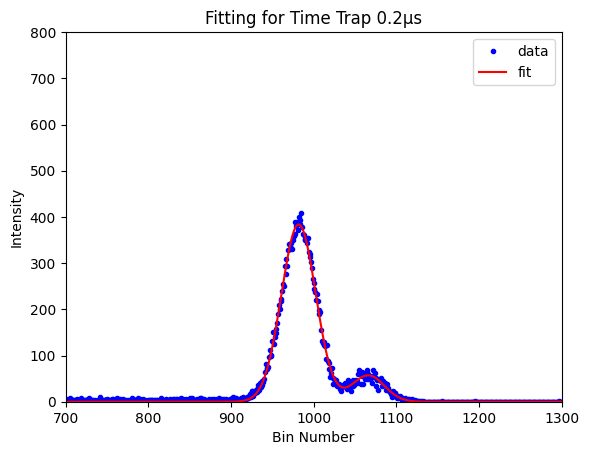

Peak 1: Mean = 1065.92, FWHM = 46.16
Peak 2: Mean = 981.83, FWHM = 48.90
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 90
    # data points      = 16383
    # variables        = 6
    chi-square         = 25380.4490
    reduced chi-square = 1.54976180
    Akaike info crit   = 7183.41151
    Bayesian info crit = 7229.63551
    R-squared          = 0.99658505
[[Variables]]
    g1_amplitude:  20086.5645 +/- 11.3685832 (0.06%) (init = 350)
    g1_center:     1037.33263 +/- 0.01018465 (0.00%) (init = 1000)
    g1_sigma:      15.6057428 +/- 0.01022530 (0.07%) (init = 50)
    g2_amplitude:  2866.72648 +/- 11.4210832 (0.40%) (init = 30)
    g2_center:     1117.22005 +/- 0.07235510 (0.01%) (init = 1100)
    g2_sigma:      15.7502613 +/- 0.07264629 (0.46%) (init = 10)
    g1_fwhm:       36.7487152 +/- 0.02407873 (0.07%) == '2.3548200*g1_sigma'
    g1_height:     513.489191 +/- 0.29020500 

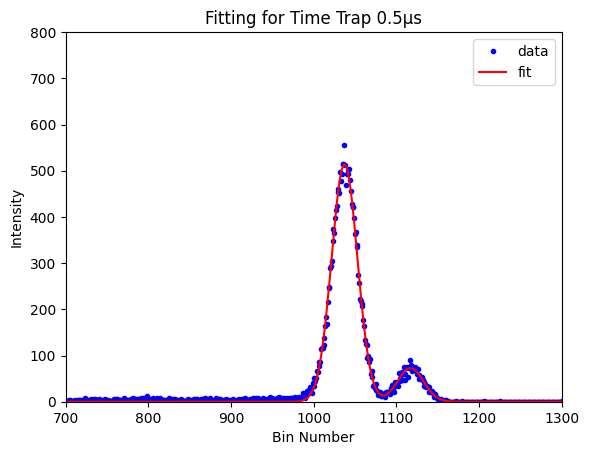

Peak 1: Mean = 1037.33, FWHM = 36.75
Peak 2: Mean = 1117.22, FWHM = 37.09
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 131
    # data points      = 16383
    # variables        = 6
    chi-square         = 39193.2841
    reduced chi-square = 2.39319070
    Akaike info crit   = 14302.2552
    Bayesian info crit = 14348.4792
    R-squared          = 0.99534811
[[Variables]]
    g1_amplitude:  19734.5491 +/- 13.0193495 (0.07%) (init = 600)
    g1_center:     1185.68433 +/- 0.01014125 (0.00%) (init = 1200)
    g1_sigma:      13.3143287 +/- 0.01014532 (0.08%) (init = 15)
    g2_amplitude:  2891.70726 +/- 13.2988341 (0.46%) (init = 50)
    g2_center:     1263.57105 +/- 0.07376011 (0.01%) (init = 1300)
    g2_sigma:      13.8910492 +/- 0.07379050 (0.53%) (init = 10)
    g1_fwhm:       31.3528475 +/- 0.02389040 (0.08%) == '2.3548200*g1_sigma'
    g1_height:     591.313810 +/- 0.3900646

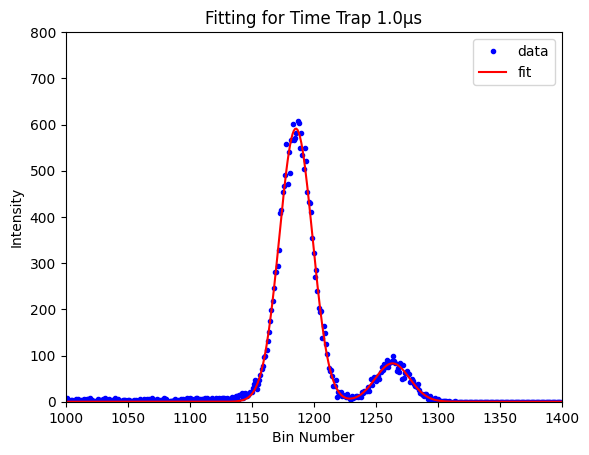

Peak 1: Mean = 1185.68, FWHM = 31.35
Peak 2: Mean = 1263.57, FWHM = 32.71
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 68
    # data points      = 16383
    # variables        = 6
    chi-square         = 34421.7165
    reduced chi-square = 2.10183285
    Akaike info crit   = 12175.4510
    Bayesian info crit = 12221.6750
    R-squared          = 0.99599836
[[Variables]]
    g1_amplitude:  19652.0859 +/- 12.0204668 (0.06%) (init = 600)
    g1_center:     1511.92948 +/- 0.00912763 (0.00%) (init = 1500)
    g1_sigma:      12.9246308 +/- 0.00913024 (0.07%) (init = 15)
    g2_amplitude:  2899.69765 +/- 12.3708219 (0.43%) (init = 50)
    g2_center:     1589.22658 +/- 0.06742659 (0.00%) (init = 1600)
    g2_sigma:      13.6881319 +/- 0.06744653 (0.49%) (init = 10)
    g1_fwhm:       30.4351792 +/- 0.02150008 (0.07%) == '2.3548200*g1_sigma'
    g1_height:     606.597467 +/- 0.37100827

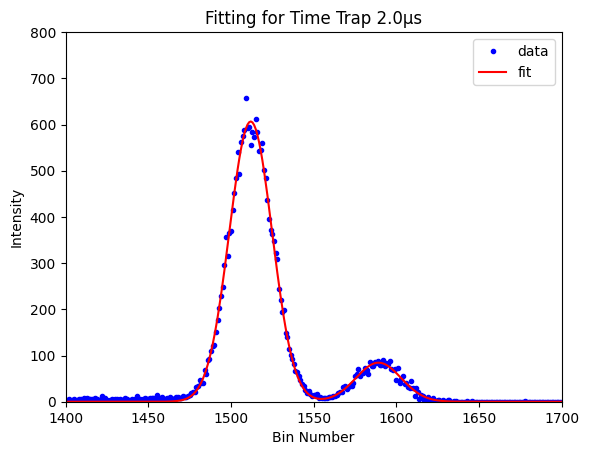

Peak 1: Mean = 1511.93, FWHM = 30.44
Peak 2: Mean = 1589.23, FWHM = 32.23
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 161
    # data points      = 16383
    # variables        = 6
    chi-square         = 50648.9983
    reduced chi-square = 3.09269087
    Akaike info crit   = 18503.0865
    Bayesian info crit = 18549.3105
    R-squared          = 0.99322708
[[Variables]]
    g1_amplitude:  2991.77953 +/- 16.7927538 (0.56%) (init = 600)
    g1_center:     2580.94095 +/- 0.10895915 (0.00%) (init = 2500)
    g1_sigma:      16.8807997 +/- 0.11024500 (0.65%) (init = 50)
    g2_amplitude:  19710.0682 +/- 15.8339841 (0.08%) (init = 50)
    g2_center:     2505.26338 +/- 0.01385951 (0.00%) (init = 2600)
    g2_sigma:      14.9989179 +/- 0.01400379 (0.09%) (init = 10)
    g1_fwhm:       39.7512448 +/- 0.25960713 (0.65%) == '2.3548200*g1_sigma'
    g1_height:     70.7044350 +/- 0.3949853

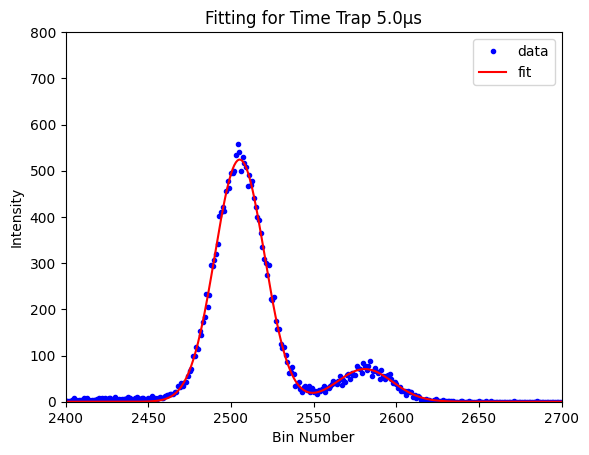

Peak 1: Mean = 2580.94, FWHM = 39.75
Peak 2: Mean = 2505.26, FWHM = 35.32
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 138
    # data points      = 16383
    # variables        = 6
    chi-square         = 53762.8240
    reduced chi-square = 3.28282494
    Akaike info crit   = 19480.5417
    Bayesian info crit = 19526.7657
    R-squared          = 0.99274883
[[Variables]]
    g1_amplitude:  2982.76319 +/- 17.1216678 (0.57%) (init = 600)
    g1_center:     2584.90412 +/- 0.10932899 (0.00%) (init = 2500)
    g1_sigma:      16.5567078 +/- 0.11050570 (0.67%) (init = 50)
    g2_amplitude:  19526.8319 +/- 16.2256605 (0.08%) (init = 50)
    g2_center:     2509.82979 +/- 0.01420867 (0.00%) (init = 2600)
    g2_sigma:      14.8613740 +/- 0.01434556 (0.10%) (init = 10)
    g1_fwhm:       38.9880666 +/- 0.26022104 (0.67%) == '2.3548200*g1_sigma'
    g1_height:     71.8711971 +/- 0.4107943

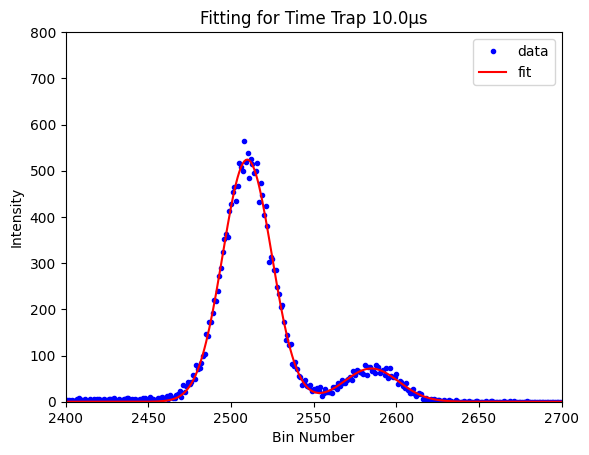

Peak 1: Mean = 2584.90, FWHM = 38.99
Peak 2: Mean = 2509.83, FWHM = 35.00


In [65]:
#Curve fitting
# Initial parameters for lower time traps
params_1000 = model_new.make_params(g1_center=1000, g1_sigma=50, g1_amplitude=350,
                           g2_center=1100, g2_sigma=10, g2_amplitude=30)


for name, data in cal_chan1000.items():
# Fit the model_new
    x = [x for x, y in data]
    y = [y for x, y in data]
    result = model_new.fit(y, params_1000, x=x)

# Print the fitting results
    print(result.fit_report())

# Plotting
    plt.plot(x, y, 'b.', label='data')
    plt.plot(x, result.best_fit, 'r-', label='fit')
    plt.xlabel('Bin Number')
    plt.ylabel('Intensity')
    plt.title('Fitting for ' +  name)
    plt.xlim([700, 1300])
    plt.ylim([0, 800])
    plt.legend()
    plt.show()

# Extracting the means and FWHMs
    mean1 = result.params['g1_center'].value
    mean2 = result.params['g2_center'].value
    fwhm1 = result.params['g1_sigma'].value * 2 * np.sqrt(2 * np.log(2))
    fwhm2 = result.params['g2_sigma'].value * 2 * np.sqrt(2 * np.log(2))

    mean1_timetrap_precalibration.append(mean1)
    mean2_timetrap_precalibration.append(mean2)
    FWHM_timetrap_precalibration.append(fwhm1)
    
    
    print(f'Peak 1: Mean = {mean1:.2f}, FWHM = {fwhm1:.2f}')
    print(f'Peak 2: Mean = {mean2:.2f}, FWHM = {fwhm2:.2f}')

#!!!!!!!!!!!!!
# Initial parameters for middle traps
params_1200 = model_new.make_params(g1_center=1200, g1_sigma=15, g1_amplitude=600,
                           g2_center=1300, g2_sigma=10, g2_amplitude=50)


for name, data in cal_chan1100.items():
# Fit the model_new
    x = [x for x, y in data]
    y = [y for x, y in data]
    result = model_new.fit(y, params_1200, x=x)

# Print the fitting results
    print(result.fit_report())

# Plotting
    plt.plot(x, y, 'b.', label='data')
    plt.plot(x, result.best_fit, 'r-', label='fit')
    plt.xlabel('Bin Number')
    plt.ylabel('Intensity')
    plt.title('Fitting for ' +  name)
    plt.xlim([1000, 1400])
    plt.ylim([0, 800])
    plt.legend()
    plt.show()

# Extracting the means and FWHMs
    mean1 = result.params['g1_center'].value
    mean2 = result.params['g2_center'].value
    fwhm1 = result.params['g1_sigma'].value * 2 * np.sqrt(2 * np.log(2))
    fwhm2 = result.params['g2_sigma'].value * 2 * np.sqrt(2 * np.log(2))

    mean1_timetrap_precalibration.append(mean1)
    mean2_timetrap_precalibration.append(mean2)
    FWHM_timetrap_precalibration.append(fwhm1)
    
    print(f'Peak 1: Mean = {mean1:.2f}, FWHM = {fwhm1:.2f}')
    print(f'Peak 2: Mean = {mean2:.2f}, FWHM = {fwhm2:.2f}')

params_1500 = model_new.make_params(g1_center=1500, g1_sigma=15, g1_amplitude=600,
                           g2_center=1600, g2_sigma=10, g2_amplitude=50)

for name, data in cal_chan1500.items():
# Fit the model_new
    x = [x for x, y in data]
    y = [y for x, y in data]
    result = model_new.fit(y, params_1500, x=x)

# Print the fitting results
    print(result.fit_report())

# Plotting
    plt.plot(x, y, 'b.', label='data')
    plt.plot(x, result.best_fit, 'r-', label='fit')
    plt.xlabel('Bin Number')
    plt.ylabel('Intensity')
    plt.title('Fitting for ' +  name)
    plt.xlim([1400, 1700])
    plt.ylim([0, 800])
    plt.legend()
    plt.show()

# Extracting the means and FWHMs
    mean1 = result.params['g1_center'].value
    mean2 = result.params['g2_center'].value
    fwhm1 = result.params['g1_sigma'].value * 2 * np.sqrt(2 * np.log(2))
    fwhm2 = result.params['g2_sigma'].value * 2 * np.sqrt(2 * np.log(2))

    mean1_timetrap_precalibration.append(mean1)
    mean2_timetrap_precalibration.append(mean2)
    FWHM_timetrap_precalibration.append(fwhm1)
    
    print(f'Peak 1: Mean = {mean1:.2f}, FWHM = {fwhm1:.2f}')
    print(f'Peak 2: Mean = {mean2:.2f}, FWHM = {fwhm2:.2f}')


#!!!!!!!!!!!!!
# Initial parameters for higher traps
params_2500 = model_new.make_params(g1_center=2500, g1_sigma=50, g1_amplitude=600,
                           g2_center=2600, g2_sigma=10, g2_amplitude=50)


for name, data in cal_chan2500.items():
# Fit the model_new
    x = [x for x, y in data]
    y = [y for x, y in data]
    result = model_new.fit(y, params_2500, x=x)

# Print the fitting results
    print(result.fit_report())

# Plotting
    plt.plot(x, y, 'b.', label='data')
    plt.plot(x, result.best_fit, 'r-', label='fit')
    plt.xlabel('Bin Number')
    plt.ylabel('Intensity')
    plt.title('Fitting for ' +  name)
    plt.xlim([2400, 2700])
    plt.ylim([0, 800])
    plt.legend()
    plt.show()

# Extracting the means and FWHMs
    mean1 = result.params['g1_center'].value
    mean2 = result.params['g2_center'].value
    fwhm1 = result.params['g1_sigma'].value * 2 * np.sqrt(2 * np.log(2))
    fwhm2 = result.params['g2_sigma'].value * 2 * np.sqrt(2 * np.log(2))

    mean1_timetrap_precalibration.append(mean1)
    mean2_timetrap_precalibration.append(mean2)
    FWHM_timetrap_precalibration.append(fwhm1)
    
    print(f'Peak 1: Mean = {mean1:.2f}, FWHM = {fwhm1:.2f}')
    print(f'Peak 2: Mean = {mean2:.2f}, FWHM = {fwhm2:.2f}')

In [66]:
print(mean1_timetrap_precalibration)
print(mean2_timetrap_precalibration)
print(FWHM_timetrap_precalibration)

[1052.4611599725938, 1065.918777366537, 1037.3326308342062, 1185.6843333266495, 1511.9294753973522, 2580.9409452704704, 2584.904120481014]
[1016.5594989671641, 981.8275331587458, 1117.220051983014, 1263.5710476817603, 1589.2265794745826, 2505.263380534589, 2509.829786463795]
[156.69286324189537, 46.16451695464032, 36.74871590482938, 31.352848082827265, 30.43517976585689, 39.7512455331981, 38.98806736875862]


In [67]:
#Linear eq. calculation
# True energy values in keV
E_Kα = 5.90
E_Kβ = 6.49

# Storage for slope (a) and intercept (b) for each dataset
a_values1 = []
b_values2 = []

# Loop through each set of mean values
for i in range(len(mean1_timetrap_precalibration)):
    mean1_LSB = mean1_timetrap_precalibration[i]
    mean2_LSB = mean2_timetrap_precalibration[i]

    # Construct the matrices for the linear equations
    A = np.array([[mean1_LSB, 1], [mean2_LSB, 1]])
    B = np.array([E_Kα, E_Kβ])

    # Solve for a and b
    a, b = np.linalg.solve(A, B)
    
    # Store the results
    a_values1.append(a)
    b_values2.append(b)
    
    print(f"Dataset {i+1}:")
    print(f"  Slope (a): {a} keV/LSB")
    print(f"  Intercept (b): {b} keV/n")


Dataset 1:
  Slope (a): -0.016433780039056392 keV/LSB
  Intercept (b): 23.19591520263975 keV/n
Dataset 2:
  Slope (a): -0.007016188255487081 keV/LSB
  Intercept (b): 13.378686807062245 keV/n
Dataset 3:
  Slope (a): 0.007385392988227722 keV/LSB
  Intercept (b): -1.7611091382227624 keV/n
Dataset 4:
  Slope (a): 0.007575104494843605 keV/LSB
  Intercept (b): -3.0816827228483454 keV/n
Dataset 5:
  Slope (a): 0.007632886212794069 keV/LSB
  Intercept (b): -5.640385647477419 keV/n
Dataset 6:
  Slope (a): -0.007796233957304668 keV/LSB
  Intercept (b): 26.021619439315653 keV/n
Dataset 7:
  Slope (a): -0.007858877574121074 keV/LSB
  Intercept (b): 26.214445023701405 keV/n


In [ ]:
#error calc
res = []

for i in range(len(mean1_timetrap_precalibration)):
    print('####################')
    print(mean1_timetrap_precalibration[i])
    print(a_values1[i])
    print(b_values2[i])
    hue = mean1_timetrap_precalibration[i]*a_values1[i] + b_values2[i]
    r = hue - 6.49
    err = abs(r)/6.49
    print(err)

In [68]:
#calibration
cs1_01 = a_values1[0]*x01 + b_values2[0]
cs1_02 = a_values1[1]*x02 + b_values2[1]
cs1_05 = a_values1[2]*x05 + b_values2[2]
cs1_10 = a_values1[3]*x10 + b_values2[3]
cs1_20 = a_values1[4]*x20 + b_values2[4]
cs1_50 = a_values1[5]*x50 + b_values2[5]
cs1_100 = a_values1[6]*x100 + b_values2[6]

# cs1names_1000 = {
# 'cal_time_trap_0.1_µs':cs1_01,
# 'cal_time_trap_0.2_µs':cs1_02
# }

# cs1names_1000pos = {'cal_time_trap_0.2_µs':cs1_05}

# cs1names_1100 = {
# 'cal_time_trap_1.0_µs':cs1_10,
# }

# cs1names_1500 = {
# 'cal_time_trap_2.0_µs':cs1_20,
# }

# cs1names_2500 = {
# 'cal_time_trap_5.0_µs':cs1_50,
# 'cal_time_trap_10.0_µs':cs1_100}

16383


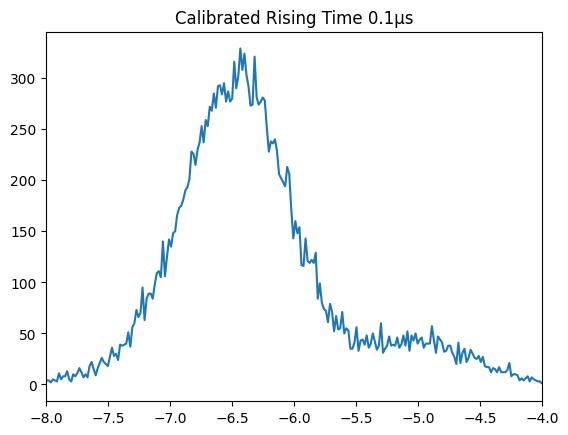

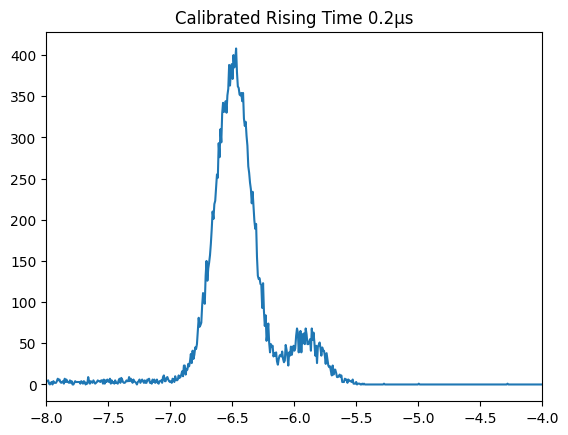

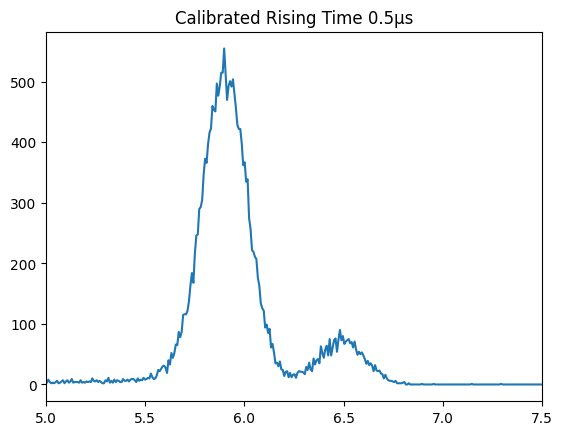

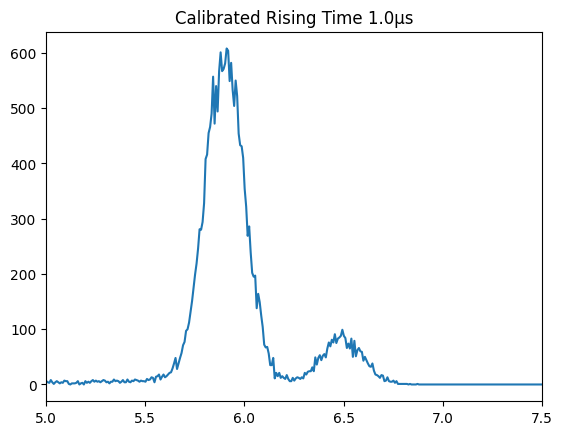

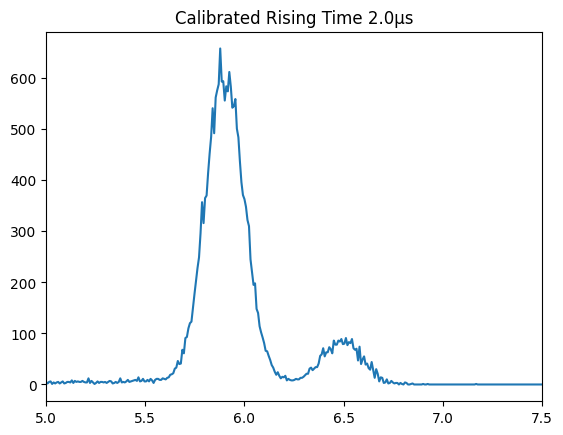

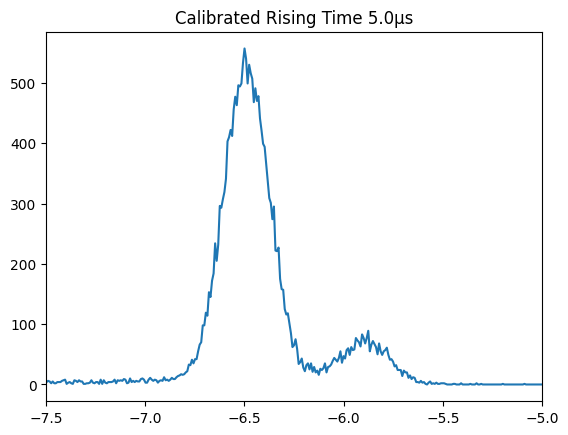

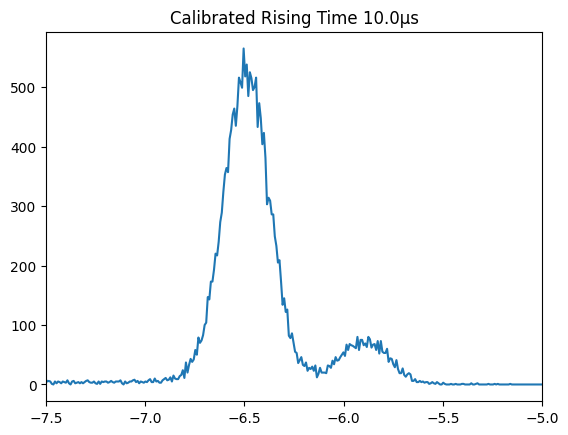

In [103]:
timetr_cal01 = list(zip(-1*cs1_01, time01))
timetr_cal02 = list(zip(-1*cs1_02, time02))
timetr_cal05 = list(zip(cs1_05, time05))
timetr_cal10 = list(zip(cs1_10, time10))
timetr_cal20 = list(zip(cs1_20, time20))
timetr_cal50 = list(zip(-1*cs1_50, time50))
timetr_cal100 = list(zip(-1*cs1_100, time100))

cs1names_1000 = {'Calibrated Rising Time 0.1µs':timetr_cal01,
            'Calibrated Rising Time 0.2µs':timetr_cal02}

cs1names_1100 = {'Calibrated Rising Time 0.5µs':timetr_cal05,
                 'Calibrated Rising Time 1.0µs':timetr_cal10}

cs1names_1500 = {'Calibrated Rising Time 2.0µs':timetr_cal20}

cs1names_2500 = {'Calibrated Rising Time 5.0µs':timetr_cal50,
            'Calibrated Rising Time 10.0µs':timetr_cal100}

haho = {'Calibrated Rising Time 0.1µs':timetr_cal01,
        'Calibrated Rising Time 0.2µs':timetr_cal02,
        'Calibrated Rising Time 0.5µs':timetr_cal05,
        'Calibrated Rising Time 1.0µs':timetr_cal10,
        'Calibrated Rising Time 2.0µs':timetr_cal20,
        'Calibrated Rising Time 5.0µs':timetr_cal50,
        'Calibrated Rising Time 10.0µs':timetr_cal100}

import matplotlib.pyplot as plt

# Just to see the full results of the calibration
print(len(timetr_cal100))

for name, data in cs1names_1000.items():
    # Extract x and y values
    x = [x for x, y in data]
    y = [y for x, y in data]

    # Create a new plot for each data set
    plt.figure()  # Start a new figure
    plt.plot(x, y, label=name)
    plt.xlim([-8, -4])
    plt.title(name)
    plt.show()  # Display the plot
#!!!!!!!!
for name, data in cs1names_1100.items():
    # Extract x and y values
    x = [x for x, y in data]
    y = [y for x, y in data]

    # Create a new plot for each data set
    plt.figure()  # Start a new figure
    plt.plot(x, y, label=name)
    plt.xlim([5, 7.5])
    plt.title(name)
    plt.show()

for name, data in cs1names_1500.items():
    # Extract x and y values
    x = [x for x, y in data]
    y = [y for x, y in data]

    # Create a new plot for each data set
    plt.figure()  # Start a new figure
    plt.plot(x, y, label=name)
    plt.xlim([5, 7.5])
    plt.title(name)
    plt.show()

for name, data in cs1names_2500.items():
    # Extract x and y values
    x = [x for x, y in data]
    y = [y for x, y in data]

    # Create a new plot for each data set
    plt.figure()  # Start a new figure
    plt.plot(x, y, label=name)
    plt.xlim([-7.5, -5])
    plt.title(name)
    plt.show()



[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 158
    # data points      = 16383
    # variables        = 6
    chi-square         = 32001.4326
    reduced chi-square = 1.95404730
    Akaike info crit   = 10981.0158
    Bayesian info crit = 11027.2398
    R-squared          = 0.99261328
[[Variables]]
    g1_amplitude:  256.151082 +/- 0.79984155 (0.31%) (init = 350)
    g1_center:    -6.49000048 +/- 5.5676e-04 (0.01%) (init = -6.5)
    g1_sigma:      0.38644463 +/- 7.3551e-04 (0.19%) (init = 1.5)
    g2_amplitude:  124.860724 +/- 0.90465341 (0.72%) (init = 50)
    g2_center:    -5.90000745 +/- 0.00796050 (0.13%) (init = -5.6)
    g2_sigma:      1.09351649 +/- 0.00543492 (0.50%) (init = 0.25)
    g1_fwhm:       0.91000756 +/- 0.00173198 (0.19%) == '2.3548200*g1_sigma'
    g1_height:     264.435039 +/- 0.46869199 (0.18%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_fwhm:

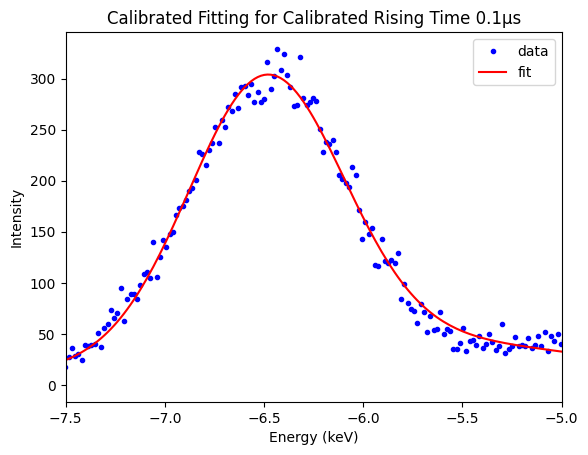

Peak 1: Mean = -6.49, FWHM = 0.91
Peak 2: Mean = -5.90, FWHM = 2.58
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 147
    # data points      = 16383
    # variables        = 6
    chi-square         = 132853.720
    reduced chi-square = 8.11221349
    Akaike info crit   = 34301.6921
    Bayesian info crit = 34347.9161
    R-squared          = 0.97603733
[[Variables]]
    g1_amplitude:  217.947120 +/- 17.0566110 (7.83%) (init = 350)
    g1_center:    -6.54821121 +/- 0.00797824 (0.12%) (init = -6.5)
    g1_sigma:      0.17016454 +/- 0.00132120 (0.78%) (init = 1.5)
    g2_amplitude: -73.9586010 +/- 17.0150308 (23.01%) (init = 50)
    g2_center:    -6.65933440 +/- 0.00379024 (0.06%) (init = -5.6)
    g2_sigma:      0.13463318 +/- 0.00452302 (3.36%) (init = 0.25)
    g1_fwhm:       0.40070687 +/- 0.00311119 (0.78%) == '2.3548200*g1_sigma'
    g1_height:     510.966169 +/- 36.7842390 

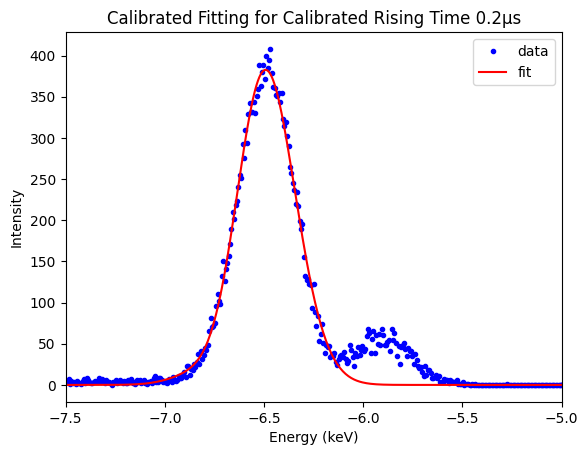

Peak 1: Mean = -6.55, FWHM = 0.40
Peak 2: Mean = -6.66, FWHM = 0.32
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 108
    # data points      = 16383
    # variables        = 6
    chi-square         = 25380.4490
    reduced chi-square = 1.54976180
    Akaike info crit   = 7183.41151
    Bayesian info crit = 7229.63551
    R-squared          = 0.99658505
[[Variables]]
    g1_amplitude:  148.347205 +/- 0.08396193 (0.06%) (init = 550)
    g1_center:     5.89999999 +/- 7.5218e-05 (0.00%) (init = 5.9)
    g1_sigma:      0.11525459 +/- 7.5519e-05 (0.07%) (init = 0.75)
    g2_amplitude:  21.1718900 +/- 0.08434844 (0.40%) (init = 100)
    g2_center:     6.49000008 +/- 5.3436e-04 (0.01%) (init = 6.4)
    g2_sigma:      0.11632175 +/- 5.3652e-04 (0.46%) (init = 0.25)
    g1_fwhm:       0.27140382 +/- 1.7783e-04 (0.07%) == '2.3548200*g1_sigma'
    g1_height:     513.489080 +/- 0.29020685 (

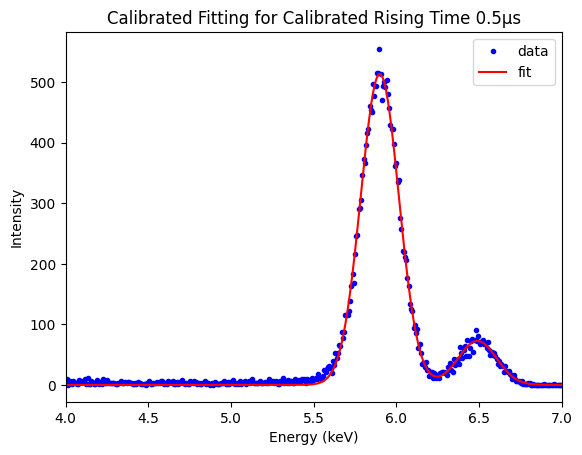

Peak 1: Mean = 5.90, FWHM = 0.27
Peak 2: Mean = 6.49, FWHM = 0.27
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 94
    # data points      = 16383
    # variables        = 6
    chi-square         = 39193.2841
    reduced chi-square = 2.39319070
    Akaike info crit   = 14302.2552
    Bayesian info crit = 14348.4792
    R-squared          = 0.99534811
[[Variables]]
    g1_amplitude:  149.491278 +/- 0.09862315 (0.07%) (init = 550)
    g1_center:     5.90000000 +/- 7.6821e-05 (0.00%) (init = 5.9)
    g1_sigma:      0.10085744 +/- 7.6852e-05 (0.08%) (init = 0.75)
    g2_amplitude:  21.9049177 +/- 0.10073244 (0.46%) (init = 100)
    g2_center:     6.48999989 +/- 5.5865e-04 (0.01%) (init = 6.4)
    g2_sigma:      0.10522551 +/- 5.5890e-04 (0.53%) (init = 0.25)
    g1_fwhm:       0.23750111 +/- 1.8097e-04 (0.08%) == '2.3548200*g1_sigma'
    g1_height:     591.313788 +/- 0.39006503 (0.0

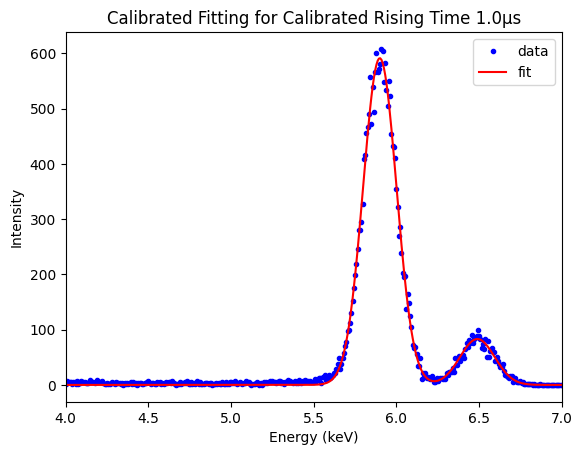

Peak 1: Mean = 5.90, FWHM = 0.24
Peak 2: Mean = 6.49, FWHM = 0.25
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 607
    # data points      = 16383
    # variables        = 6
    chi-square         = 34421.7165
    reduced chi-square = 2.10183285
    Akaike info crit   = 12175.4510
    Bayesian info crit = 12221.6750
    R-squared          = 0.99599836
[[Variables]]
    g1_amplitude:  150.002140 +/- 0.09175107 (0.06%) (init = 600)
    g1_center:     5.90000000 +/- 6.9670e-05 (0.00%) (init = 5.9)
    g1_sigma:      0.09865224 +/- 6.9690e-05 (0.07%) (init = 75)
    g2_amplitude:  22.1330607 +/- 0.09442414 (0.43%) (init = 100)
    g2_center:     6.49000012 +/- 5.1465e-04 (0.01%) (init = 6.4)
    g2_sigma:      0.10447994 +/- 5.1479e-04 (0.49%) (init = 75)
    g1_fwhm:       0.23230828 +/- 1.6411e-04 (0.07%) == '2.3548200*g1_sigma'
    g1_height:     606.597446 +/- 0.37100863 (0.06%)

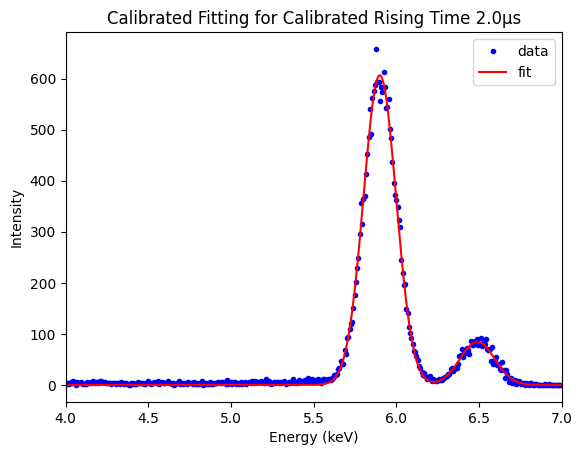

Peak 1: Mean = 5.90, FWHM = 0.23
Peak 2: Mean = 6.49, FWHM = 0.25
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 298
    # data points      = 16383
    # variables        = 6
    chi-square         = 197697.806
    reduced chi-square = 12.0716741
    Akaike info crit   = 40813.7865
    Bayesian info crit = 40860.0105
    R-squared          = 0.97356330
[[Variables]]
    g1_amplitude:  313.133175 +/- 47.3385716 (15.12%) (init = 350)
    g1_center:    -6.55594882 +/- 0.00818633 (0.12%) (init = -6.5)
    g1_sigma:      0.13704963 +/- 7.8416e-04 (0.57%) (init = 1.5)
    g2_amplitude: -157.089625 +/- 47.3207596 (30.12%) (init = 50)
    g2_center:    -6.62043257 +/- 0.00415481 (0.06%) (init = -5.6)
    g2_sigma:      0.11710318 +/- 0.00363322 (3.10%) (init = 0.25)
    g1_fwhm:       0.32272721 +/- 0.00184656 (0.57%) == '2.3548200*g1_sigma'
    g1_height:     911.509721 +/- 136.029431 (

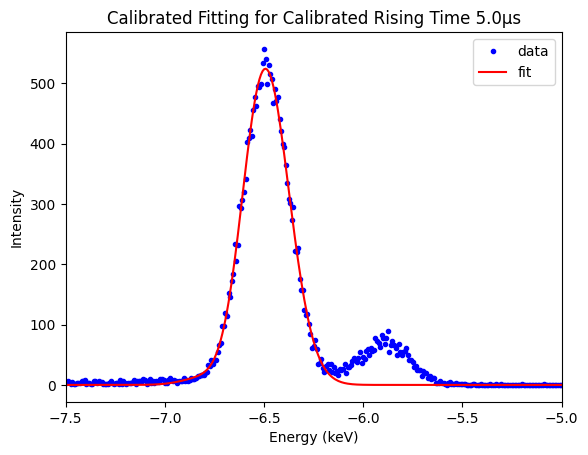

Peak 1: Mean = -6.56, FWHM = 0.32
Peak 2: Mean = -6.62, FWHM = 0.28
[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 127
    # data points      = 16383
    # variables        = 6
    chi-square         = 203103.957
    reduced chi-square = 12.4017804
    Akaike info crit   = 41255.7723
    Bayesian info crit = 41301.9963
    R-squared          = 0.97260672
[[Variables]]
    g1_amplitude:  255.263865 +/- 33.2539791 (13.03%) (init = 350)
    g1_center:    -6.53952047 +/- 0.00858177 (0.13%) (init = -6.5)
    g1_sigma:      0.13251880 +/- 0.00108668 (0.82%) (init = 1.5)
    g2_amplitude: -99.5376430 +/- 33.2199946 (33.37%) (init = 50)
    g2_center:    -6.61412331 +/- 0.00434889 (0.07%) (init = -5.6)
    g2_sigma:      0.11009850 +/- 0.00436776 (3.97%) (init = 0.25)
    g1_fwhm:       0.31205792 +/- 0.00255894 (0.82%) == '2.3548200*g1_sigma'
    g1_height:     768.461181 +/- 95.5603854

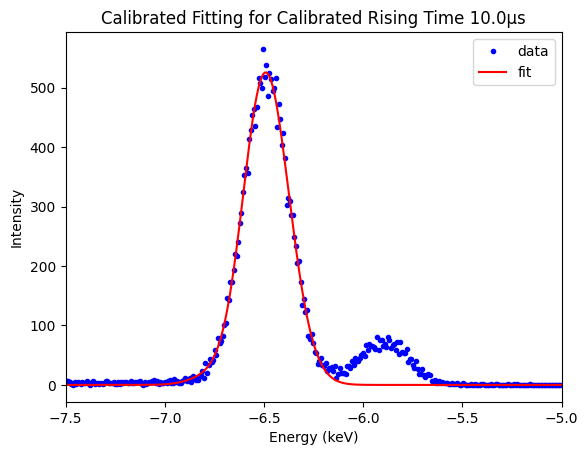

Peak 1: Mean = -6.54, FWHM = 0.31
Peak 2: Mean = -6.61, FWHM = 0.26


In [106]:
#further fitting for calibrated spectra
fwhm_cal = []
#Curve fitting
# Initial parameters for lower time traps
paramss_1000 = model_new.make_params(g1_center=-6.5, g1_sigma=1.5, g1_amplitude=350,
                           g2_center=-5.6, g2_sigma=0.25, g2_amplitude=50)


for name, data in cs1names_1000.items():
# Fit the model_new
    x = [x for x, y in data]
    y = [y for x, y in data]
    result = model_new.fit(y, paramss_1000, x=x)

# Print the fitting results
    print(result.fit_report())
    
# Plotting
    plt.plot(x, y, 'b.', label='data')
    plt.plot(x, result.best_fit, 'r-', label='fit')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Intensity')
    plt.title('Calibrated Fitting for ' +  name)
    plt.xlim([-7.5, -5])
    #plt.ylim([-10, 50])
    plt.legend()
    plt.show()

# Extracting the means and FWHMs
    mean1 = result.params['g1_center'].value
    mean2 = result.params['g2_center'].value
    fwhm1 = result.params['g1_sigma'].value * 2 * np.sqrt(2 * np.log(2))
    fwhm2 = result.params['g2_sigma'].value * 2 * np.sqrt(2 * np.log(2))

    # mean1_timetrap_precalibration.append(mean1)
    # mean2_timetrap_precalibration.append(mean2)
    fwhm_cal.append(fwhm1)
    
    
    print(f'Peak 1: Mean = {mean1:.2f}, FWHM = {fwhm1:.2f}')
    print(f'Peak 2: Mean = {mean2:.2f}, FWHM = {fwhm2:.2f}')

#!!!!!!!!!!!!!
#!!!!!!!!!!!!!
# Initial parameters for middle traps
params_1200 = model_new.make_params(g1_center=5.9, g1_sigma=0.75, g1_amplitude=550,
                           g2_center=6.4, g2_sigma=0.25, g2_amplitude=100)


for name, data in cs1names_1100.items():
# Fit the model_new
# Fit the model_new
    x = [x for x, y in data]
    y = [y for x, y in data]
    result = model_new.fit(y, params_1200, x=x)

# Print the fitting results
    print(result.fit_report())
    
# Plotting
    plt.plot(x, y, 'b.', label='data')
    plt.plot(x, result.best_fit, 'r-', label='fit')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Intensity')
    plt.title('Calibrated Fitting for ' +  name)
    plt.xlim([4, 7])
    #plt.ylim([-10, 50])
    plt.legend()
    plt.show()

# Extracting the means and FWHMs
    mean1 = result.params['g1_center'].value
    mean2 = result.params['g2_center'].value
    fwhm1 = result.params['g1_sigma'].value * 2 * np.sqrt(2 * np.log(2))
    fwhm2 = result.params['g2_sigma'].value * 2 * np.sqrt(2 * np.log(2))

    # mean1_timetrap_precalibration.append(mean1)
    # mean2_timetrap_precalibration.append(mean2)
    fwhm_cal.append(fwhm1)
    
    
    print(f'Peak 1: Mean = {mean1:.2f}, FWHM = {fwhm1:.2f}')
    print(f'Peak 2: Mean = {mean2:.2f}, FWHM = {fwhm2:.2f}')

# Initial parameters for middle traps
params_1500 = model_new.make_params(g1_center=5.9, g1_sigma=75, g1_amplitude=600,
                           g2_center=6.4, g2_sigma=75, g2_amplitude=100)


for name, data in cs1names_1500.items():
# Fit the model_new
    x = [x for x, y in data]
    y = [y for x, y in data]
    result = model_new.fit(y, params_1500, x=x)

# Print the fitting results
    print(result.fit_report())
    
# Plotting
    plt.plot(x, y, 'b.', label='data')
    plt.plot(x, result.best_fit, 'r-', label='fit')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Intensity')
    plt.title('Calibrated Fitting for ' +  name)
    plt.xlim([4, 7])
    #plt.ylim([-10, 50])
    plt.legend()
    plt.show()

# Extracting the means and FWHMs
    mean1 = result.params['g1_center'].value
    mean2 = result.params['g2_center'].value
    fwhm1 = result.params['g1_sigma'].value * 2 * np.sqrt(2 * np.log(2))
    fwhm2 = result.params['g2_sigma'].value * 2 * np.sqrt(2 * np.log(2))

    # mean1_timetrap_precalibration.append(mean1)
    # mean2_timetrap_precalibration.append(mean2)
    fwhm_cal.append(fwhm1)
    
    
    print(f'Peak 1: Mean = {mean1:.2f}, FWHM = {fwhm1:.2f}')
    print(f'Peak 2: Mean = {mean2:.2f}, FWHM = {fwhm2:.2f}')
    
#!!!!!!!!!!!!!
# Initial parameters for higher traps
params_2500 = model_new.make_params(g1_center=-6.5, g1_sigma=1.5, g1_amplitude=350,
                           g2_center=-5.6, g2_sigma=0.25, g2_amplitude=50)



for name, data in cs1names_2500.items():
# Fit the model_new
    x = [x for x, y in data]
    y = [y for x, y in data]
    result = model_new.fit(y, params_2500, x=x)

# Print the fitting results
    print(result.fit_report())
    
# Plotting
    plt.plot(x, y, 'b.', label='data')
    plt.plot(x, result.best_fit, 'r-', label='fit')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Intensity')
    plt.title('Calibrated Fitting for ' +  name)
    plt.xlim([-7.5, -5])
    #plt.ylim([-10, 50])
    plt.legend()
    plt.show()

# Extracting the means and FWHMs
    mean1 = result.params['g1_center'].value
    mean2 = result.params['g2_center'].value
    fwhm1 = result.params['g1_sigma'].value * 2 * np.sqrt(2 * np.log(2))
    fwhm2 = result.params['g2_sigma'].value * 2 * np.sqrt(2 * np.log(2))

    # mean1_timetrap_precalibration.append(mean1)
    # mean2_timetrap_precalibration.append(mean2)
    fwhm_cal.append(fwhm1)
    
    
    print(f'Peak 1: Mean = {mean1:.2f}, FWHM = {fwhm1:.2f}')
    print(f'Peak 2: Mean = {mean2:.2f}, FWHM = {fwhm2:.2f}')


In [107]:
print(fwhm_cal)

[0.9100075725427594, 0.40070688051572717, 0.2714038267927906, 0.2375011192139137, 0.2323082801313756, 0.3227272129202776, 0.3120579256143934]


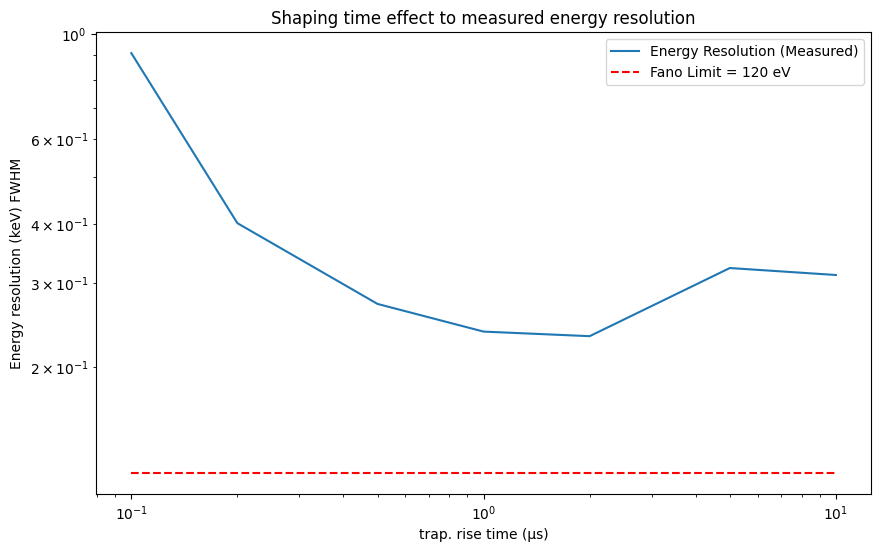

In [112]:
trap_risetime = [0.1, 0.2, 0.5, 1, 2, 5, 10] 
fano_error = 0.12
plt.figure(figsize=(10, 6)) 
plt.plot(trap_risetime, fwhm_cal, label = 'Energy Resolution (Measured)')
plt.plot(trap_risetime, [fano_error] * len(trap_risetime), 'r--', label=f'Fano Limit = 120 eV')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('trap. rise time (µs)')
plt.ylabel('Energy resolution (keV) FWHM')
plt.legend()
plt.title('Shaping time effect to measured energy resolution')
save_current_plot('noise_curve.png')
plt.show()